# Práctica 2: Ejercicio 2 - Datos Energía: Modelos predictivos univariantes

**Asignatura**: Machine Learning, 2025/2026

**Profesor**: José Tomás Palma Méndez

**Máster de Inteligencia Artificial**
**Autores:**  
- Jesús Guirado Pérez  
- Antonio Luis Sánchez Torres  
- Víctor Emilio Vicente García

## Índice
1. [Introducción](#intro)
2. [Librerías y datasets](#librerias)
3. [Partición de los datos](#particion)
4. [Entrenamiento de modelo baseline](#base)
5. [Entrenamiento de modelos principales](#modelos)
   1. [XGBoost](#xgboost)
   2. [Random Forest](#random)
   3. [SVR](#svr)
6. [Comparación de modelos y conclusiones](#conclu)

 [Consultas a IA Generativa](#genia)

 [Librerías utilizadas](#entorno)

## Introducción <a class="anchor" id="intro"></a>

A continuación, pasaremos a la construcción de modelos predictivos univariantes. Es decir, intentaremos usar únicamente la información pasada de la propia variable objetivo para intentar predecirla en el futuro. Como se nos indica en el enunciado, buscamos predecir los 7 días siguientes a partir de los datasets dados, por tanto, tenemos un horizonte temporal de 7 días. Recordemos que la variable objetivo es la energía total consumida en un barrio.

## Librerías y datasets <a class="anchor" id="librerias"></a>

Lo primero que hacemos es importar las librerías que vamos a utilizar.

In [1]:
# Predicción univariante de series temporales
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import random


from skforecast.metrics import root_mean_squared_scaled_error
from sklearn.metrics import mean_absolute_error,root_mean_squared_error, mean_squared_error,mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_squared_scaled_error
from xgboost import XGBRegressor

from skforecast.recursive import ForecasterRecursive
from skforecast.utils import save_forecaster

# Semillas para reproducibilidad
random.seed(123)
np.random.seed(123)

f:\UMU\Master IA\ML\practica1\.ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ahora cargamos los datos que ya hemos analizado y preprocesado en el apartado anterior.

In [2]:
# Cargamos nuestros dos datasets
energia_pre = pd.read_csv("Data/energia_preprocesada.csv", index_col=0, parse_dates=True)

Comprobamos que se ha cargado correctamente.

In [3]:
energia_pre

Día de la semana  Electricidad (kW)  Fotovoltaica (kW)  \
2014-01-01                 2         490049.280           62795.47   
2014-01-02                 3         556486.560           64284.00   
2014-01-03                 4         545831.450           67187.06   
2014-01-04                 5         511495.560           46798.28   
2014-01-05                 6         502806.800           70162.87   
...                      ...                ...                ...   
2022-12-27                 1         387412.640           30088.60   
2022-12-28                 2         383053.165            5414.64   
2022-12-29                 3         394671.370           19596.24   
2022-12-30                 4         399327.275           13443.79   
2022-12-31                 5         377951.010           24692.67   

            Refrigeración (kW)  Calefacción (kWh)  Energía total (kWh)  \
2014-01-01        243369.71770        20107.60131         753526.59901   
2014-01-02        323886.05169        23987.86135         904360.47304   
2014-01-03        337004.60237        22112.20695         904948.25932   
2014-01-04        252493.06189        21074.73561         785063.35750   
2014-01-05        249265.37031        22777.47812         774849.64843   
...                        ...                ...                  ...   
2022-12-27        342464.92072        53687.67649         783565.23721   
2022-12-28        305114.02902        53895.75690         742062.95092   
2022-12-29        312909.24850        60730.17262         768310.79112   
2022-12-30        334773.31206        59543.23507         793643.82213   
2022-12-31        337341.95301        57289.51908         772582.48209   

            Emisión (kg CO₂)  
2014-01-01          469960.0  
2014-01-02          564020.0  
2014-01-03          564390.0  
2014-01-04          489640.0  
2014-01-05          483270.0  
...                      ...  
2022-12-27          486790.0  
2022-12-28          461820.0  
2022-12-29          479160.0  
2022-12-30          494110.0  
2022-12-31          481590.0  

[3287 rows x 7 columns]

Como estamos realizando predicción con modelos univariantes, nos quedamos sólo con la variable energía total. Haremos, por tanto, modelos predictivos autorregresivos en los que se usarán los datos de la serie temporal de esta variable para predecir los datos futuros.

In [4]:
#energia_pre.info()
energia_serie = pd.Series(energia_pre['Energía total (kWh)'])
energia_serie = energia_serie.asfreq('D')
energia_serie

2014-01-01    753526.59901
2014-01-02    904360.47304
2014-01-03    904948.25932
2014-01-04    785063.35750
2014-01-05    774849.64843
                  ...     
2022-12-27    783565.23721
2022-12-28    742062.95092
2022-12-29    768310.79112
2022-12-30    793643.82213
2022-12-31    772582.48209
Freq: D, Name: Energía total (kWh), Length: 3287, dtype: float64

Volvemos a comprobar que todos los datos están correctos. Deben ser 3287 entradas en punto flotante.

In [5]:
energia_serie.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3287 entries, 2014-01-01 to 2022-12-31
Freq: D
Series name: Energía total (kWh)
Non-Null Count  Dtype  
--------------  -----  
3287 non-null   float64
dtypes: float64(1)
memory usage: 51.4 KB


Vemos que todo ha ido bien. Vemos también que la frecuencia es diaria. Volvemos a comprobar que no nos faltan índices de fechas.

In [6]:
fechas_esperadas =  pd.date_range(start=energia_serie.index.min(), end=energia_serie.index.max(), freq='D')
fechas_perdidas = fechas_esperadas.difference(energia_serie.index)
print(f'Número de fechas faltantes: {len(fechas_perdidas)}')
fechas_perdidas

Número de fechas faltantes: 0


DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Comprobamos visualmente que los datos de la serie están correctos en el dataset nuevo.

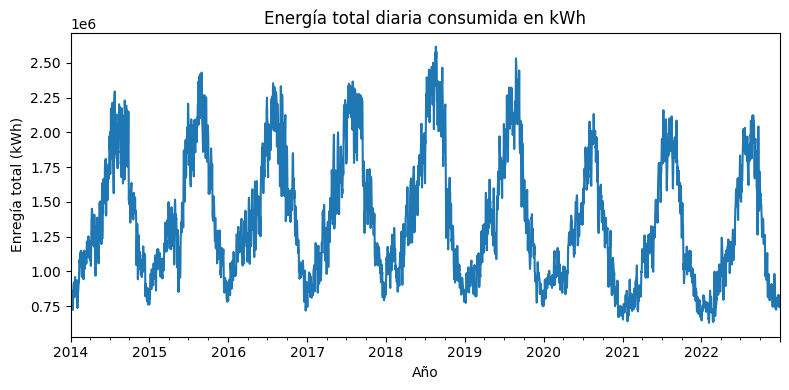

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
energia_serie.plot(ax=ax)
ax.set_xlabel('Año')
ax.set_ylabel('Enregía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
fig.tight_layout()
plt.show()

Todo ha ido bien, aquí tenemos la serie temporal con la que trabajaremos en este notebook.

## Partición de los datos: Entrenamiento y Test <a class="anchor" id="particion"></a>

Lo que vamos a hacer a continuación es separar los valores de nuestra variable en datos de entrenamiento y test. Haremos un Hold-Out con un 80% de datos para entrenamiento y un 20% de datos para test. Debemos recordar que, como estamos tratando con series temporales, debemos hacer la partición de forma cronológica. Esto es, no podemos dividir los datos aleatoriamente, sino que los datos de entrenamiento serán los del principio de la serie (el 80% primero) y los de test serán los últimos que hay en esta (el 20% último). Como tenemos más de 3000 valores, hacemos una partición 80/20 en vez de una 90/10 porque consideramos que con más de 2600 valores tendremos más que suficientes datos para entrenar los modelos. Además, queremos tener suficientes datos de test para poder evaluar los modelos de forma más precisa.

In [8]:
porcentaje_split = .8
test_steps = int(len(energia_serie) * porcentaje_split)
energia_train = pd.Series(energia_serie[:test_steps])
energia_test = pd.Series(energia_serie[test_steps:])
print(f'Con el porcentaje de %.2f tenemos:' %porcentaje_split)
print(f'Tamaño del conjunto de training es %i' %len(energia_train))
print(f'Tamaño del conjunto de test es %i' %len(energia_test))
print(f'El conjunto de training va de {min(energia_train.index)} y {max(energia_train.index)}')
print(f'El conjunto de test va de {min(energia_test.index)} y {max(energia_test.index)}')

Con el porcentaje de 0.80 tenemos:
Tamaño del conjunto de training es 2629
Tamaño del conjunto de test es 658
El conjunto de training va de 2014-01-01 00:00:00 y 2021-03-13 00:00:00
El conjunto de test va de 2021-03-14 00:00:00 y 2022-12-31 00:00:00


Veamos visualmente cómo hemos hecho la partición.

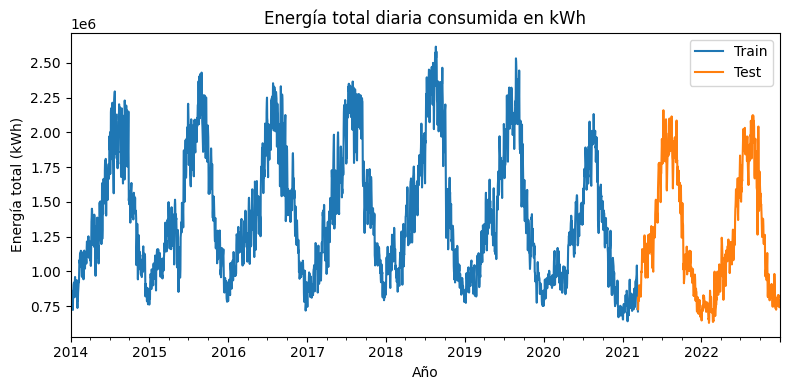

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
energia_train.plot(ax=ax, label='train')
energia_test.plot(ax=ax, label='test')
ax.legend(labels=['Train', 'Test'], loc='best')
ax.set_xlabel('Año')
ax.set_ylabel('Energía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
fig.tight_layout()
plt.show()

Vemos que efectivamente, hemos realizado correctamente la partición de los datos. Vemos además, cómo se respeta la partición cronológica: los datos de entrenamiento van desde 2014 hasta principios de 2021 y los de test, desde comienzos del 2021 hasta el final del 2022.

## Entrenamiento de modelo baseline <a class="anchor" id="base"></a>

Como primera aproximación a la predicción de los datos, vamos a entrenar un primer modelo baseline. Como su nombre indica, este nos servirá como modelo de línea base a partir del cual intentaremos mejorar el rendimiento ofrecido en los futuros modelos. Por tanto, no haremos ningún tipo de transformación ni diferenciación en los datos en este primer entrenamiento. Además, como buscamos un primer modelo base fácil de computar, tampoco haremos búsqueda de hiperpárametros en este modelo y usaremos sus parámetros por defecto. 


Vamos a utilizar un **modelo de línea base simple** basado en la media entre el día anterior al horizonte y el mismo día del año anterior.

Con esta estrategia lo que pretendemos es intentar capturar tanto la tendencia reciente como la estacionalidad anual de forma simple y computacionalmente eficiente.

**Estrategia para horizonte de 7 días:**
- **h=1**: Predicción = media(último_día_train, mismo_día_año_anterior)
- **h=2**: Predicción = media(predicción_h1, día_año_anterior_correspondiente)
- **h=3 a h=7**: Se continúa usando la predicción anterior y el día del año anterior correspondiente

Este modelo es simple pero efectivo en series temporales como esta con fuerte estacionalidad anual y puede servirnos como referencia para compararlo con modelos más complejos.

Tambien hemos estudiado la alternativa de usar solo el día anterior para cada predicción, por eso nuestra función nos permite elegir si utilizar la media de dos días o solo el día anterior con el parámetro 'media2dias'. Tras evaluar con el conjunto de train y test, obtuvimos los mejores resultados utilizando la media entre el último día conocido y el mismo día del año anterior. Por lo que finalmente hemos utilizado este modelo.

Como esquema de predicción, **usaremos la técnica recursiva** en toda la práctica puesto que, a pesar de que el error se va acumulando a lo largo de las predicciones, esta mantiene la dependencia estadística temporal de las mismas. Además, al ser el horizonte temporal a predecir tan pequeño (7 días) en comparación con todo el volumen de datos que tenemos, esperamos que el error acumulado sea muy pequeño. También escogemos esta estrategia por ser **más eficiente computacionalmente**, puesto que sólo entrenamos un modelo cada vez (frente a los 7 que entrenaríamos si utilizásemos la predicción directa), y esto será importante cuando tengamos que usar varias variables o tengamos grandes parrillas de hiperparámetros. Usaremos como ventana temporal **365 días**, puesto que ya vimos en el análisis de los datos que hay una estacionalidad que se corresponde con un año de los datos.



Creamos la función para el método baseline que hemos descrito.

In [10]:
# Función para crear predicciones baseline con media de día anterior + mismo día año anterior
def crear_baseline_predicciones(train_data, media2Dias=False,horizonte=7):
    predicciones = []
    fechas_pred = []
    
    # Obtener el último valor de train y su índice
    ultimo_idx_train = train_data.index[-1]
    ultimo_valor = train_data.iloc[-1]
    
    for h in range(1, horizonte + 1):
        # Fecha de la predicción
        fecha_pred = ultimo_idx_train + pd.Timedelta(days=h)
        fechas_pred.append(fecha_pred)
        
        # Fecha del mismo día del año anterior
        fecha_año_anterior = fecha_pred - pd.Timedelta(days=365)
        
        idx_cercano = train_data.index.get_indexer([fecha_año_anterior], method='nearest')[0]
        valor_año_anterior = train_data.iloc[idx_cercano]
        
        # Para h=1, usar el último día de train
        # Para h>1, usar la predicción anterior
        if h == 1:
            valor_anterior = ultimo_valor
        else:
            valor_anterior = predicciones[-1]
        
        # Predicción como media simple
        
        if(media2Dias):
            pred = (valor_anterior + valor_año_anterior) / 2
            predicciones.append(pred)
        else:
            predicciones.append(valor_anterior)
    
    # Crear serie con las predicciones
    predicciones_serie = pd.Series(predicciones, index=fechas_pred, name='pred')
    
    return predicciones_serie



Una vez definido el modelo, generamos las predicciones para los 7 primeros días.

In [11]:
# Crear predicciones baseline
prediccion_inicial = crear_baseline_predicciones(energia_train, media2Dias=True, horizonte=7)

# Convertir a DataFrame para mantener consistencia con código posterior
prediccion_inicial = pd.DataFrame(prediccion_inicial)

Vemos la representación gráfica de las predicciones.

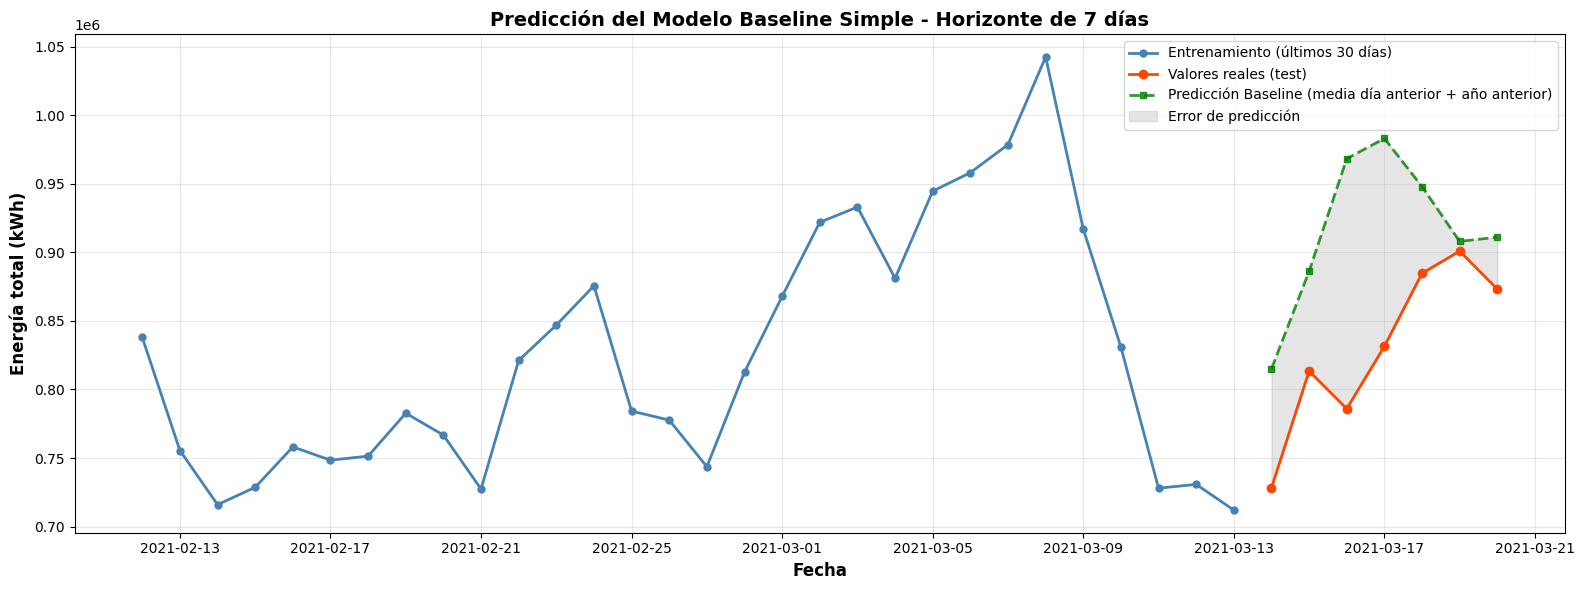

In [12]:
# Visualizar la predicción del modelo baseline
fig, ax = plt.subplots(figsize=(16, 6))

# Mostrar últimos 30 días de entrenamiento
ultimos_dias_train = energia_train.iloc[-30:]
ax.plot(ultimos_dias_train.index, ultimos_dias_train, 
        'o-', color='steelblue', label='Entrenamiento (últimos 30 días)', 
        linewidth=2, markersize=5)

# Mostrar primeros 7 días de test (valores reales)
primeros_dias_test = energia_test.iloc[:7]
ax.plot(primeros_dias_test.index, primeros_dias_test, 
        'o-', color='orangered', label='Valores reales (test)', 
        linewidth=2, markersize=6)

# Mostrar predicción del baseline
ax.plot(prediccion_inicial.index, prediccion_inicial['pred'], 
        's--', color='green', label='Predicción Baseline (media día anterior + año anterior)', 
        linewidth=2, markersize=5, alpha=0.8)

# Área sombreada para el error
ax.fill_between(primeros_dias_test.index, 
                primeros_dias_test, 
                prediccion_inicial['pred'],
                alpha=0.2, color='gray', label='Error de predicción')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Energía total (kWh)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicción del Modelo Baseline Simple - Horizonte de 7 días', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Podemos ver que con este método obtenemos una predicción bastante buena pese a la simplicidad del modelo. Vemos que se distancia más de los datos reales entre los días 2 y 4, mientras que las predicciones para los tres últimos días son las más cercanas de todas. Veremos ahora qué métricas usamos para evaluar este modelo y los próximos que desarrollemos para intentar mejorarlo. 

### Evaluación del modelo

Hacemos ahora el cálculo de las métricas de error. Escogemos como métricas principales el error medio absoluto (`MAE`), la raíz del error cuadrático medio (`RMSE`), la raíz del error cuadrático medio escalado (`RMSSE`) y el error porcentual absoluto medio (`MAPE`).


**Interpretación de las métricas:**
- **MAE** (Mean Absolute Error): Error absoluto medio en kWh. Más bajo es mejor. Elegimos esta métrica porque es más directa e intuitiva para analizar el error cometido. El error está en las mismas unidades de la serie y es más robusta a valores atípicos que métricas cuadráticas.
- **RMSE** (Root Mean Squared Error): Penaliza más los errores grandes. Más bajo es mejor. Elegimos esta métrica porque es más sensible a cambios bruscos grandes. Es útil en problema como este en los que queremos minimizar errores extremos para predecir, por ejemplo, cuánta energía se deberá producir para un barrio determinado.
- **RMSSE** (Root Mean Squared Scaled Error): Mide el error del modelo escalado por el error de un modelo ingenuo, respetando la estructura temporal. Si la medida es mayor a 1.0, quiere decir que el modelo es peor que uno que simplemente repite el mismo dato del día anterior. Buscamos, por tanto, valores entre 0.0 y 1.0. El RMSSE evalúa el funcionamiento relativo del modelo frente a una predicción mínima razonable, lo cual es crucial en series temporales. Nos permite saber si el modelo realmente mejora un baseline simple.
- **MAPE** (Mean Absolute Percentage Error): Error porcentual medio. Más bajo es mejor. Elegimos esta métrica porque nos da en porcentaje el error medio cometido. Esto hace que sea muy fácil de interpretar y que sea independiente de la escala.

`A la hora de comparar entre modelos nos centraremos especialmente en el RMSSE y el MAPE, puesto que consideramos que son las métricas más informativas y descriptivas, ya que no dependen de la escala del problema y nos dan una medida rápida e interpretable de su eficacia.`

Procedemos ahora a construir una función que nos calcule estas métricas dadas unas predicciones y sus valores reales.

In [13]:
# Función para calcular métricas de evaluación
def calcular_metricas(y_true, y_pred, y_train, nombre_modelo="Modelo", verbose=True):
    """
    Calcula métricas de evaluación para predicciones de series temporales.
    
    Métricas:
    - MAE: Mean Absolute Error
    - RMSE: Root Mean Squared Error
    - RMSSE: Root Mean Squared Scaled Error
    - MAPE: Mean Absolute Percentage Error
    """
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    # RMSE
    rmse = root_mean_squared_error(y_true, y_pred)  # raíz del MSE
    
    # MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred) *100
    
    # RMSSE
    rmsse = np.sqrt(mean_squared_scaled_error(y_true, y_pred, y_train=y_train, sp=7))
    
    resultados = {
        'Modelo': nombre_modelo,
        'MAE': mae,
        'RMSE': rmse,
        'RMSSE': rmsse,
        'MAPE': mape
    }
    
    if verbose:
        print(f"\nMétricas de {nombre_modelo}:")
        print(f"  • MAE   = {mae:.3f} kWh")
        print(f"  • RMSE  = {rmse:.3f} kWh")
        print(f"  • RMSSE = {rmsse:.4f}")
        print(f"  • MAPE  = {mape:.2f}%")
    
    return resultados

Ahora, procedemos a crear una función personalizada que nos permita calcular las predicciones para cada uno de los puntos de test. Lo hacemos de forma que podamos crear la predicción del horizonte temporal (los 7 días siguientes) para cada uno de ellos. De esta manera, podremos calcular los errores del h+1, h+2, .. h+7 de manera independiente para cada uno de los datos de test. Lo que hacemos será: **escogemos los últimos datos de training, creamos las predicciones de los siguiente 7 días, calculamos los errores y movemos en un día la ventana, por lo que la nueva ventana temporal contendrá un dato menos del conjunto de training y el primer dato del conjunto de test.** Repetimos esto para todo el conjunto de test.

In [14]:
# Función para calcular errores por horizonte de predicción de forma individual
def calcular_errores_por_horizonte(modelo, test_data, train_data=None, offset_lags=0, exog_test=None, horizonte=7, target_col='Energía total (kWh)', verbose=True):
    # Si se proporcionan datos de train, concatenarlos con test para tener suficientes lags
    if train_data is not None:
        # Concatenar últimos 365 días de train con test
        datos_completos = pd.concat([train_data.tail(offset_lags), test_data])
        # Ajustar índice de inicio
        offset = offset_lags
    else:
        datos_completos = test_data
        offset = 0
    
    # Inicializar listas para almacenar errores
    errores_por_ventana = []
    predicciones_lista = []
    
    # Calcular cuántas ventanas de predicción podemos hacer
    n_ventanas = len(test_data) - horizonte + 1
    
    # Para cada ventana de inicio en el conjunto de test
    for i in range(n_ventanas):
        # Índice en test_data
        idx_test = i
        # Índice en datos_completos
        idx_completo = i + offset
        
        # Fecha de inicio de la predicción
        fecha_inicio = test_data.index[idx_test]
        
        # Realizar predicción para los próximos 'horizonte' días
        # Datos hasta el punto de predicción (incluye train si está disponible)
        datos_hasta_punto = datos_completos.iloc[:idx_completo]
        
        if  exog_test is not None:
            # Variables exógenas para el periodo de predicción
            exog_periodo = exog_test.iloc[idx_test:idx_test+horizonte]
            pred = modelo.predict(steps=horizonte, 
                                 last_window=datos_hasta_punto, exog=exog_periodo)
        else:
            pred = modelo.predict(steps=horizonte,
                                 last_window=datos_hasta_punto)
        
        # Obtener valores reales para este periodo
        y_true = test_data.iloc[idx_test:idx_test+horizonte].values
        
        # Extraer predicciones solo para la serie objetivo
        # pred puede ser un DataFrame con múltiples series
        y_pred = pred

        # Asegurarse de que las dimensiones coinciden
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]
        # Calcular error absoluto para cada día del horizonte
        errores_ventana = np.abs(y_true - y_pred)
        
       # Calcular errores
        error_abs = np.abs(y_true - y_pred)
        error_squared = (y_true - y_pred) ** 2
        error_pct = np.abs((y_true - y_pred) / y_true) * 100
        
        # Guardar predicciones
        for h in range(min_len):
            predicciones_lista.append({
                'ventana': i,
                'fecha_inicio': fecha_inicio,
                'horizonte_dia': h + 1,
                'fecha_pred': test_data.index[idx_test + h],
                'valor_real': float(y_true[h]),
                'valor_pred': float(y_pred.iloc[h]),
                'error_absoluto': float(error_abs.iloc[h]),
                'error_cuadrado': float(error_squared.iloc[h]),
                'error_porcentual': float(error_pct.iloc[h])
            })
        
        # Guardar errores de esta ventana
        errores_ventana_dict = {'ventana': i, 'fecha_inicio': fecha_inicio}
        for h in range(min_len):
            errores_ventana_dict[f'mae_h{h+1}'] = float(error_abs.iloc[h])
            errores_ventana_dict[f'mse_h{h+1}'] = float(error_squared.iloc[h])
            errores_ventana_dict[f'mape_h{h+1}'] = float(error_pct.iloc[h])

        errores_por_ventana.append(errores_ventana_dict)
    
    # Crear DataFrames
    df_errores = pd.DataFrame(errores_por_ventana)
    df_predicciones = pd.DataFrame(predicciones_lista)
    
    if len(df_predicciones) == 0:
        return None
    
    # Calcular métricas por horizonte
    metricas_por_h = []
    for h in range(1, horizonte + 1):
        # Filtrar predicciones para este horizonte
        pred_h = df_predicciones[df_predicciones['horizonte_dia'] == h]
        
        y_true_h = pred_h['valor_real'].values
        y_pred_h = pred_h['valor_pred'].values
        y_train = train_data.values if train_data is not None else None

        # MAE
        mae = mean_absolute_error(y_true_h, y_pred_h)

        # RMSE
        rmse = root_mean_squared_error(y_true_h, y_pred_h)  # raíz del MSE
        # MAPE
        mape = mean_absolute_percentage_error(y_true_h, y_pred_h) *100
        # RMSSE

        rmsse = np.sqrt(mean_squared_scaled_error(y_true_h, y_pred_h, y_train=y_train, sp=7))
        
        metricas_por_h.append({
            'Horizonte': f'h+{h}',
            'MAE': mae,
            'RMSE': rmse,
            'RMSSE': rmsse,
            'MAPE': mape
        })
    
    df_metricas = pd.DataFrame(metricas_por_h)
    
    # Calcular métricas globales (promedio de todos los horizontes)
    metricas_globales = {
        'MAE': df_metricas['MAE'].mean(),
        'RMSE': df_metricas['RMSE'].mean(),
        'RMSSE': df_metricas['RMSSE'].mean(),
        'MAPE': df_metricas['MAPE'].mean()
    }

    return {
        'metricas_por_horizonte': df_metricas,
        'metricas_globales': metricas_globales,
        'errores_detallados': df_errores,
        'predicciones': df_predicciones
    }

# Función para visualizar errores por horizonte
def visualizar_errores_horizonte(resultados, titulo="Análisis de Errores por Horizonte"):
    df_metricas = resultados['metricas_por_horizonte']
    df_predicciones = resultados['predicciones']
        
    n_horizontes = df_predicciones['horizonte_dia'].nunique()
    fig, axes = plt.subplots(n_horizontes, 1, figsize=(16, 4 * n_horizontes))
    
    if n_horizontes == 1:
        axes = [axes]
    
    for h in range(1, n_horizontes + 1):
        ax = axes[h - 1]
        
        # Filtrar datos para este horizonte
        datos_h = df_predicciones[df_predicciones['horizonte_dia'] == h].sort_values('fecha_pred')
        
        # Plotear valores reales y predichos
        ax.plot(datos_h['fecha_pred'], datos_h['valor_real'], 
               'o-', color='steelblue', label='Valores Reales', 
               linewidth=2, markersize=4, alpha=0.8)
        
        ax.plot(datos_h['fecha_pred'], datos_h['valor_pred'], 
               's--', color='orangered', label='Predicciones', 
               linewidth=2, markersize=4, alpha=0.8)
        
        # Área de error
        ax.fill_between(datos_h['fecha_pred'], 
                        datos_h['valor_real'], 
                        datos_h['valor_pred'],
                        alpha=0.2, color='gray')
        
        # Métricas para este horizonte
        metrica_h = df_metricas[df_metricas['Horizonte'] == f'h+{h}'].iloc[0]
        texto_metricas = (f"MAE: {metrica_h['MAE']:.2f} | "
                         f"RMSE: {metrica_h['RMSE']:.2f} | "
                         f"RMSSE: {metrica_h['RMSSE']:.4f} | "
                         f"MAPE: {metrica_h['MAPE']:.2f}%")
        
        ax.set_xlabel('Fecha', fontsize=11, fontweight='bold')
        ax.set_ylabel('Energía (kWh)', fontsize=11, fontweight='bold')
        ax.set_title(f'Horizonte h+{h} - {texto_metricas}', 
                    fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Rotar etiquetas de fecha si hay muchos puntos
        if len(datos_h) > 30:
            ax.tick_params(axis='x', rotation=45)
    
    plt.suptitle(f'{titulo} - Predicciones por Horizonte', 
                fontsize=14, fontweight='bold', y=0.9995)
    plt.tight_layout()
    plt.show()

Creamos ahora un método personalizado para evaluar el funcionamiento del modelo baseline para todo el conjunto de test.


Evaluando baseline con rolling window en TRAIN...
  Horizonte: 7 días
  Rango de evaluación: desde índice 365 hasta 1892
  Total de predicciones por horizonte: 1528
  Fechas: desde 2016-12-31 00:00:00 hasta 2021-03-07 00:00:00

Evaluando baseline con rolling window en TEST...
  Horizonte: 7 días
  Rango de evaluación: desde índice 365 hasta 1016
  Total de predicciones por horizonte: 652
  Fechas: desde 2021-03-14 00:00:00 hasta 2022-12-25 00:00:00

TRAIN:
  MAE: 156241.7445
  RMSE: 202863.7456
  RMSSE: 1.1509
  MAPE: 11.84%

TEST:
  MAE: 116176.8626
  RMSE: 150693.5094
  RMSSE: 0.8549
  MAPE: 9.28%


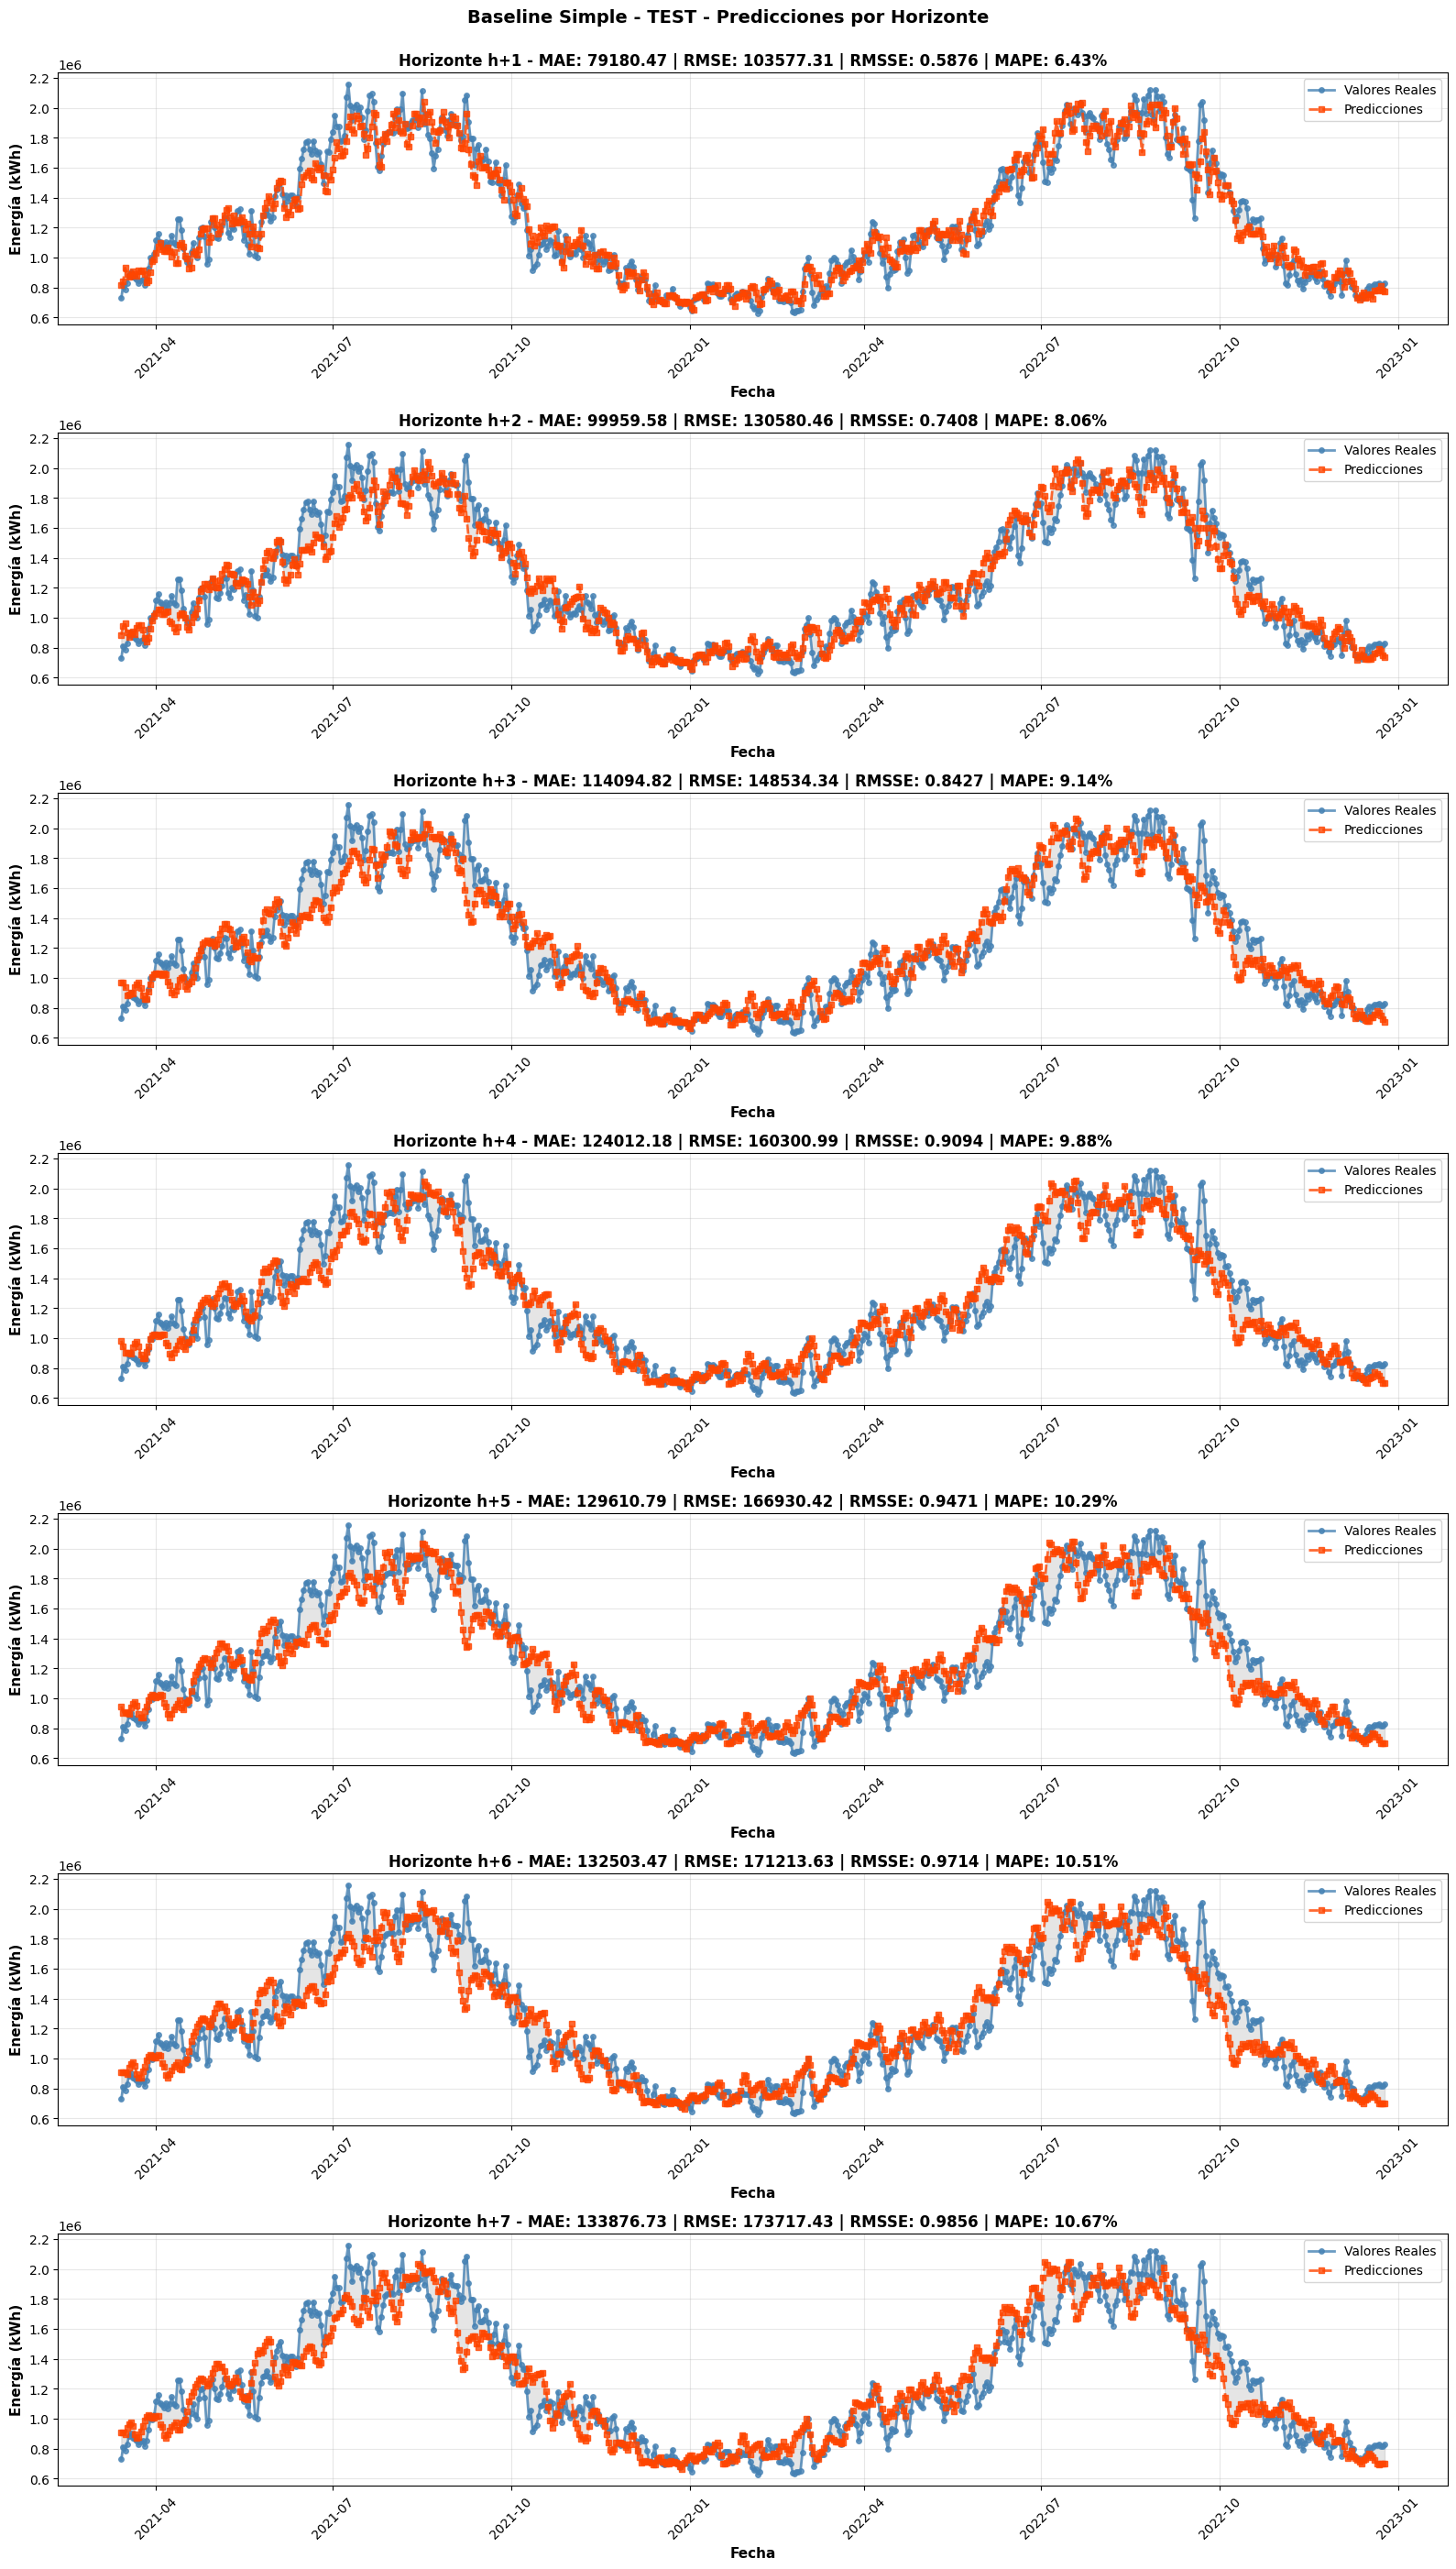

In [16]:
# Función para evaluar el baseline simple en un conjunto de datos con rolling window
def evaluar_baseline_simple(datos, horizonte, media2Dias=True,verbose=True, nombre_conjunto="datos"):
    # Diccionarios para almacenar predicciones de cada horizonte
    predicciones_por_horizonte = {h: [] for h in range(1, horizonte + 1)}
    valores_reales = []
    fechas = []
    
    # Necesitamos al menos 365 días para poder usar el año anterior
    # y poder predecir al menos horizonte días adelante
    min_inicio = 365
    
    if verbose:
        print(f"\nEvaluando baseline con rolling window en {nombre_conjunto}...")
        print(f"  Horizonte: {horizonte} días")
        print(f"  Rango de evaluación: desde índice {min_inicio} hasta {len(datos) - horizonte}")
    
    # Recorremos los datos dejando espacio para predecir 'horizonte' días adelante
    for i in range(min_inicio, len(datos) - horizonte + 1):
        # Datos disponibles hasta este punto (sin mirar hacia adelante)
        datos_hasta_aqui = datos.iloc[:i]
        
        # Para cada horizonte h
        for h in range(1, horizonte + 1):
            # Índice del día que queremos predecir
            idx_pred = i + h - 1
            
            # Valor real del día a predecir
            if h == 1:
                # Solo guardamos valores reales una vez (para h=1)
                valor_real = datos.iloc[idx_pred]
                valores_reales.append(valor_real)
                fechas.append(datos.index[idx_pred])
            
            # Calcular predicción para este horizonte
            # Usamos el valor de h-1 días antes (o el último disponible si h=1)
            if h == 1:
                # Para h=1, usamos el último valor disponible (i-1)
                valor_dia_anterior = datos_hasta_aqui.iloc[-1]
            else:
                valor_dia_anterior = predicciones_por_horizonte[h - 1][-1]
            
            # Mismo día del año anterior respecto al día que queremos predecir
            idx_año_anterior = idx_pred - 365
            if idx_año_anterior >= 0 and idx_año_anterior < i:
                valor_año_anterior = datos_hasta_aqui.iloc[idx_año_anterior]
            else:
                # Si no tenemos el valor exacto del año anterior, usamos el más cercano disponible
                # dentro de datos_hasta_aqui
                idx_año_anterior_cercano = max(0, min(idx_año_anterior, i - 1))
                valor_año_anterior = datos_hasta_aqui.iloc[idx_año_anterior_cercano]
            
            if media2Dias:
                # Predicción como media simple
                pred = (valor_dia_anterior + valor_año_anterior) / 2
                predicciones_por_horizonte[h].append(pred)
            else:
                pred = (valor_año_anterior)
                predicciones_por_horizonte[h].append(pred)
    # Convertir a arrays numpy
    y_true = np.array(valores_reales)
    resultados = {'y_true': y_true, 'fechas': fechas}
    
    for h in range(1, horizonte + 1):
        resultados[f'y_h{h}'] = np.array(predicciones_por_horizonte[h])
    
    if verbose:
        print(f"  Total de predicciones por horizonte: {len(valores_reales)}")
        print(f"  Fechas: desde {fechas[0]} hasta {fechas[-1]}")
    
    return resultados

# 1. Evaluar en TRAIN con rolling window
resultados_train = evaluar_baseline_simple(
    datos=energia_train[730:], # Usamos desde el año 3 en adelante como en backtesting
    horizonte=7,
    media2Dias=True,
    nombre_conjunto="TRAIN"
)

# Calcular métricas para cada horizonte en TRAIN
metricas_baseline_train_por_horizonte = {}
for h in range(1, 7 + 1):
    metricas = calcular_metricas(
        resultados_train['y_true'], 
        resultados_train[f'y_h{h}'], 
        energia_train.values,
        f"Baseline - TRAIN (h={h})",
        False
    )
    metricas_baseline_train_por_horizonte[f'h{h}'] = metricas

# 2. Evaluar en TEST con rolling window
# Concatenamos el último año de train para poder predecir usando año anterior
resultados_test = evaluar_baseline_simple(
    datos=pd.concat([energia_train[-365:], energia_test]),
    horizonte=7,
    media2Dias=True,
    nombre_conjunto="TEST"
)

# Calcular métricas para cada horizonte en TEST
metricas_baseline_test_por_horizonte = {}
for h in range(1, 7 + 1):
    metricas = calcular_metricas(
        resultados_test['y_true'], 
        resultados_test[f'y_h{h}'],
        energia_train.values, 
        f"Baseline - TEST (h={h})",
        verbose=False
    )
    metricas_baseline_test_por_horizonte[f'h{h}'] = metricas

# Crear diccionario compatible con visualizar_errores_horizonte para TEST
def crear_dict_visualizacion(resultados_eval, metricas_por_h, horizonte):
    """
    Crea un diccionario compatible con la función visualizar_errores_horizonte
    """
    # DataFrame de métricas por horizonte
    metricas_list = []
    for h in range(1, horizonte + 1):
        m = metricas_por_h[f'h{h}']
        metricas_list.append({
            'Horizonte': f'h+{h}',
            'MAE': m['MAE'],
            'RMSE': m['RMSE'],
            'RMSSE': m['RMSSE'],
            'MAPE': m['MAPE']
        })
    df_metricas = pd.DataFrame(metricas_list)
    
    # DataFrame de predicciones detalladas
    predicciones_list = []
    y_true = resultados_eval['y_true']
    fechas = resultados_eval['fechas']
    
    for i in range(len(y_true)):
        for h in range(1, horizonte + 1):
            y_pred_h = resultados_eval[f'y_h{h}'][i]
            predicciones_list.append({
                'ventana': i,
                'horizonte_dia': h,
                'fecha_pred': fechas[i],
                'valor_real': float(y_true[i]),
                'valor_pred': float(y_pred_h),
                'error_absoluto': float(np.abs(y_true[i] - y_pred_h)),
                'error_cuadrado': float((y_true[i] - y_pred_h) ** 2),
                'error_porcentual': float(np.abs((y_true[i] - y_pred_h) / y_true[i]) * 100) if y_true[i] != 0 else 0
            })
    
    df_predicciones = pd.DataFrame(predicciones_list)
    
    # Métricas globales (promedio de todos los horizontes)
    metricas_globales = {
        'MAE': df_metricas['MAE'].mean(),
        'RMSE': df_metricas['RMSE'].mean(),
        'RMSSE': df_metricas['RMSSE'].mean(),
        'MAPE': df_metricas['MAPE'].mean()
    }
    
    return {
        'metricas_por_horizonte': df_metricas,
        'metricas_globales': metricas_globales,
        'predicciones': df_predicciones
    }

# Crear diccionarios para visualización
dict_visualizacion_train = crear_dict_visualizacion(resultados_train, metricas_baseline_train_por_horizonte, 7)
dict_visualizacion_test = crear_dict_visualizacion(resultados_test, metricas_baseline_test_por_horizonte, 7)

# Mostrar métricas globales
print("\nTRAIN:")
for metrica, valor in dict_visualizacion_train['metricas_globales'].items():
    if metrica == 'MAPE':
        print(f"  {metrica}: {valor:.2f}%")
    else:
        print(f"  {metrica}: {valor:.4f}")

print("\nTEST:")
for metrica, valor in dict_visualizacion_test['metricas_globales'].items():
    if metrica == 'MAPE':
        print(f"  {metrica}: {valor:.2f}%")
    else:
        print(f"  {metrica}: {valor:.4f}")

# Guardar resultados para comparación posterior con las medias de todos los horizontes
metricas_baseline_train_media = {
    'Modelo': 'Baseline Simple - TRAIN (media horizontes)',
    **dict_visualizacion_train['metricas_globales']
}

metricas_baseline_test_media = {
    'Modelo': 'Baseline Simple - TEST (media horizontes)',
    **dict_visualizacion_test['metricas_globales']
}

resultados_modelos_cv = [metricas_baseline_train_media]
resultados_modelos_test = [metricas_baseline_test_media]

# Visualizar errores en TEST
visualizar_errores_horizonte(dict_visualizacion_test, titulo="Baseline Simple - TEST")


Como métricas finales para este primer modelo baseline obtenemos, para el conjunto de test, **un MAE del 116176.8626, un RMSE del 150693.5094, un RMSSE del 0.8549 y un MAPE del 9.28%**.

Podemos ver que obtenemos unas predicciones buenas a pesar de la sencillez con la que las calculamos con este modelo. Vemos visualmente en las gráficas, cómo va aumentando el error a medida que avanzamos en las predicciones consecutivas del modelo. Es decir, el error es inferior para la predicción del primer día, que para las predicciones del resto. Por tanto, tal y como habíamos señalado, el error se va acumulando y hace que las métricas vayan empeorando progresivamente conforme nos movemos en el horizonte de predicción. Esto se debe al uso de la predicción recursiva. Vemos que comenzamos con **un RMSSE del 0.588 y un MAPE del 6.43% para el h+1** y el error va aumentando poco a poco, hasta alcanzar **un RMSSE del 0.986 y un MAPE del 10.67% para el h+7**.

Intentaremos mejorar estos datos con los modelos principales que entrenaremos y compararemos.

## Entrenamiento de modelos principales <a class="anchor" id="modelos"></a>

A continuación, entrenaremos los modelos principales que usaremos para crear nuestras predicciones. Elegimos como modelos principales los siguientes:
* **XGBoost**. Escogemos este por ser muy eficiente computacionalmente y mostrar muy buen rendimiento en problemas complejos. Además, incluye regularización, lo que disminuye el overfitting. Además, es fácil de interpretar porque se basan en potenciación de gradiente de árboles de regresión. Nos permite además calcular la importancia relativa de las variables.
* **RandomForest**. Escogemos este por ser muy robusto y permitir una gran interpretabilidad de los resultados calculados. Nos permite también calcular la importancia relativa de las variables.
* **SVR**. Escogemos este por ser muy eficaz en datasets medianos y ser menos sensible al ruido que otros modelos. Es adecuado cuando buscamos una buena generalización.

Ordenamos según su interpretabilidad, tenemos que RandomForest es el más interpretable de los 3 y SVR el que menos. Esto puede ser también una característica a tener en cuenta cuando los modelos tengan rendimientos muy similares.

Intentaremos mejorar los resultados anteriores del modelo baseline ajustando estos modelos haciendo una búsqueda con grid de hiperparámetros.

### XGBoost <a class="anchor" id="xgboost"></a>

Creamos nuestro modelo XGBoost. Al igual que antes usaremos predicción recursiva.

In [17]:

# Creamos el modelo con predicción recursiva
forecaster_XGB = ForecasterRecursive(
                 regressor       = XGBRegressor(random_state=123, n_jobs=-1),
                 lags            = 365, #este valor se sobreecribe en la búsqueda de hiperparámetros
                 differentiation = None
             )

C:\Users\vecto\AppData\Local\Temp\ipykernel_25184\554260495.py:2: FutureWarning: The `regressor` argument is deprecated and will be removed in a future version. Please use `estimator` instead.
  forecaster_XGB = ForecasterRecursive(


Definimos nuestros grids para las variables lag y el grid de hiperparámetros de nuestro modelo. Para los hiperparámetros usamos los valores por defecto y los variamos ligeramente:

* **learning_rate**: escogemos el valor por defecto, 0.3, y los disminuimos ligeramente, 0.2 y 0.1. Valores pequeños suelen funcionar bien para las tasas de aprendizaje.
* **max_depth**: escogemos el valor por defector, 6, y escogemos uno mayor y otro menor, 3 y 9. Normalmente, árboles más profunods son más exactos pero tienen más riesgo de overfitting.
* **min_child_weight**: escogemos el valor por defecto, 1, lo aumentamos ligeramente, 3 y 5. Cuanto más grande sea el valor, más conservador será el algoritmo al hacer la regresión e incluir instancias en los nodos.


Para el grid de lags, usamos como ventana temporal: 
* Una semana de datos, **7 días**, porque como hemos visto en el notebook anterior, la serie presenta una gran autocorrelación para los datos de la semana anterior, por lo que puede haber una estacionalidad semanal. 
* Un mes, **30 días**, porque también vimos que había una correlación notable para los datos del mes anterior, pudiendo haber estacionalidad mensual.
* Medio año, **183 días**, porque vimos que existía una correlación negativa notable para cada dato de la serie con los del medio año anterior.
* Un año, **365 días**, porque hemos visto que la serie tiene estacionalidad anual.
* La semana anterior y la misma semana del año anterior, porque si tiene una gran correlación con la semana anterior y una estacionalidad anual, es posible que sólo estos 14 valores sean suficientes para realizar una buena predicción.

In [18]:
lags_grid = [7, 30, 183 ,365, [1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 364, 365]]

#Creamos el grid de hiperparámetros
param_grid_xgboost = {
    'learning_rate': [0.3, 0.2,0.1],
    'max_depth': [3,6,9],
    'min_child_weight': [1,3,5],
    
}

Antes de entrenar el modelo, definimos la técnica de muestreo que usaremos. Usamos 7 steps, puesto que tenemos que predecir los próximos 7 días. Usamos un tamaño inicial de entrenamiento de 730, para incluir los valores de los dos primeros años en el primer entrenamiento del modelo. Cuanto más grande sea este valor, menos pliegues tendremos en la validación cruzada. Consideramos 2 años justos como para tener suficientes datos y no tener demasiados pliegues. No reentrenamos el modelo en cada pliegue. Usamos una ventana de 365 para cada pliegue; usamos ventana deslizante, por lo que el tamaño de entrenamiento siempre es fijo; no usamos gap y permitimos que el último pliegue esté incompleto; y por último, **no usamos diferenciación** porque, como vimos en el análisis de los datos, se trata de una serie estacionaria. 


In [19]:
from skforecast.model_selection import grid_search_forecaster, random_search_forecaster
from skforecast.model_selection import TimeSeriesFold

cv = TimeSeriesFold(
         steps                 = 7,
         initial_train_size    = 730,
         fold_stride           = None,
         window_size           = 365,
         refit                 = False,
         fixed_train_size      = True,
         gap                   = 0,
         allow_incomplete_fold = True,
         differentiation       = None,
         verbose               = False
     )

Pasamos ahora a optimizar el modelo usando el grid de hiperparámetros.

In [20]:
results_grid_XGB = grid_search_forecaster(
                   forecaster         = forecaster_XGB,
                   y                  = energia_train,
                   param_grid         = param_grid_xgboost,
                   lags_grid          = lags_grid,
                   cv                 = cv,
                   metric             = 'root_mean_squared_scaled_error',
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )


lags grid: 100%|██████████| 5/5 [01:24<00:00, 16.81s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5}
  Backtesting metric: 1.4165521498501363


Vemos que los mejores parámetros son **0.1** para learning rate, **3** para max_depth y **5** para min_child_weight. La métrica de raíz de error cuadrático medio escalado del mejor modelo ha sido de **1.41**. Sin embargo, esto no tiene en cuenta el error del método agregado según cada uno de los días del horizonte de predicción, tal y como nosotros hacemos.

Vemos los errores y parámetros de cada modelo del grid.

In [21]:
results_grid_XGB

lags  \
0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1                                [1, 2, 3, 4, 5, 6, 7]   
2    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3                                [1, 2, 3, 4, 5, 6, 7]   
4    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
..                                                 ...   
130  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
131  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
132  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
133  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
134  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                            lags_label  \
0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1                                [1, 2, 3, 4, 5, 6, 7]   
2    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3                                [1, 2, 3, 4, 5, 6, 7]   
4    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
..                                                 ...   
130  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
131  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
132  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
133  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
134  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                                params  \
0    {'learning_rate': 0.1, 'max_depth': 3, 'min_ch...   
1    {'learning_rate': 0.1, 'max_depth': 3, 'min_ch...   
2    {'learning_rate': 0.1, 'max_depth': 3, 'min_ch...   
3    {'learning_rate': 0.1, 'max_depth': 3, 'min_ch...   
4    {'learning_rate': 0.1, 'max_depth': 3, 'min_ch...   
..                                                 ...   
130  {'learning_rate': 0.2, 'max_depth': 9, 'min_ch...   
131  {'learning_rate': 0.3, 'max_depth': 9, 'min_ch...   
132  {'learning_rate': 0.3, 'max_depth': 6, 'min_ch...   
133  {'learning_rate': 0.3, 'max_depth': 9, 'min_ch...   
134  {'learning_rate': 0.2, 'max_depth': 9, 'min_ch...   

     root_mean_squared_scaled_error  learning_rate  max_depth  \
0                          1.416552            0.1        3.0   
1                          1.425850            0.1        3.0   
2                          1.425959            0.1        3.0   
3                          1.426815            0.1        3.0   
4                          1.427245            0.1        3.0   
..                              ...            ...        ...   
130                        1.785880            0.2        9.0   
131                        1.786364            0.3        9.0   
132                        1.794198            0.3        6.0   
133                        1.795205            0.3        9.0   
134                        1.820804            0.2        9.0   

     min_child_weight  
0                 5.0  
1                 1.0  
2                 1.0  
3                 5.0  
4                 3.0  
..                ...  
130               5.0  
131               5.0  
132               3.0  
133               3.0  
134               1.0  

[135 rows x 7 columns]

Veamos los parámetros del mejor modelo.

In [22]:
forecaster_XGB

=================== 
ForecasterRecursive 
=================== 
Estimator: XGBRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window features: None 
Window size: 30 
Series name: Energía total (kWh) 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2021-03-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Estimator parameters: 
    {'objective': 'reg:squarederror', 'base_score': None, 'booster': None,
    'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,
    'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None,
    'enable_categorical': False, 'eval_metric': None, 'feature_types': None,
    'feature_weights': None, 'gamma': None, 'grow_policy': None,
    'importance_type': None, 'interaction_constraints': None, 'learning_rate':
    0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None,
    'max_delta_step': None, 'max_depth': 3, 'max_leaves': None,
    'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None,
    'multi_strategy': None, 'n_estimators': None, 'n_jobs': -1,
    'num_parallel_tree': None, 'random_state': 123, 'reg_alpha': None,
    'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None,
    'subsample': None, 'tree_method': None, 'validate_parameters': None,
    'verbosity': None} 
fit_kwargs: {} 
Creation date: 2026-01-08 02:25:45 
Last fit date: 2026-01-08 02:27:09 
Skforecast version: 0.19.1 
Python version: 3.12.7 
Forecaster id: None

Vemos que los mejores parámetros son **0.1** para learning rate, **3** para max_depth y **5** para min_child_weight. El mejor número de lags detectado es **30**.  Puesto que estamos ante un modelo basado en árboles de decisión, podemos ver cuál es la importancia de las características que usa. Vemos la importancia que el modelo da a los lags seleccionados.

In [23]:
# Vemos la importanca de las características
importance_df =forecaster_XGB.get_feature_importances().sort_values(ascending=False, by='importance')
importance_df['importance'] = importance_df['importance'] * 100
    
print(importance_df.head(20).to_string(
    formatters={'importance': '{:.2f}%'.format}
))

   feature importance
0    lag_1     66.30%
5    lag_6     11.50%
6    lag_7     10.25%
13  lag_14      1.58%
4    lag_5      0.78%
12  lag_13      0.75%
19  lag_20      0.56%
23  lag_24      0.54%
20  lag_21      0.47%
18  lag_19      0.47%
27  lag_28      0.44%
22  lag_23      0.44%
29  lag_30      0.44%
15  lag_16      0.42%
28  lag_29      0.42%
25  lag_26      0.39%
21  lag_22      0.39%
8    lag_9      0.39%
14  lag_15      0.37%
11  lag_12      0.34%


Podemos ver cómo, sobre todo, el valor más importante es el del día anterior, con un 66.3% de importancia. Después, los siguientes más imporantes son el valor de hace 6 días y de hace una semana, con 11.5% y 10.25% respectivamente. Veamos ahora cómo se comporta prediciendo el conjunto de test. 

**Predecimos primero usando como horizonte todos los puntos de test, para ver cómo se comporta.**

In [24]:
predicciones_grid = forecaster_XGB.predict(steps=len(energia_test))
predicciones_grid

2021-03-14    780449.2500
2021-03-15    835755.1875
2021-03-16    838011.5625
2021-03-17    824586.6250
2021-03-18    813639.3125
                 ...     
2022-12-27    923938.5000
2022-12-28    923938.5000
2022-12-29    923938.5000
2022-12-30    923938.5000
2022-12-31    923938.5000
Freq: D, Name: pred, Length: 658, dtype: float64

A simple vista, los valores parecen muy similares. Comparamos gráficamente las predicciones con los valores reales de test.

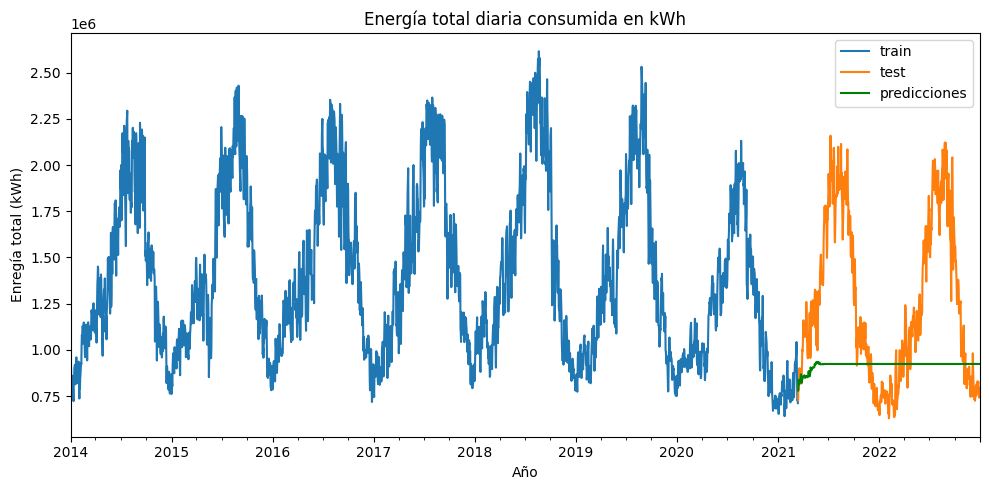

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax, label='train')
energia_test.plot(ax=ax, label='test')
predicciones_grid.plot(ax=ax, label='predicciones', color='green')
ax.set_xlabel('Año')
ax.set_ylabel('Enregía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend()
fig.tight_layout()
plt.show()

Vemos que el modelo predice muy mal los ejemplos de test. A simple vista en la gráfica, como indicábamos antes, todos los valores son aproximadamente iguales. Sin embargo, esto puede tener una explicación muy clara: el modelo se ha entrenado para predecir un horizonte temporal de 7 valores, o sea, para predecir 7 días. Y aquí, le estamos pidiendo que nos prediga todo el conjunto de test, que se trata de un total de 658 valores. Por tanto, como estamos usando predicción recursiva, los errores en cada predicción se van acumulando poco a poco hasta el punto de que los valores se van estabilizando y como el mejor modelo usa un lag de 30 días, se van generando valores iguales. Entonces, **esta gráfica no nos está mostrando adecuadamente cómo se comporta nuestro modelo** cuando lo que queremos predecir son sólo los próximos 7 días.

Antes de solucionar esto, veamos cuáles son los errores según estas predicciones.

In [26]:
error_mae = mean_absolute_error(
                y_true = energia_test,
                y_pred = predicciones_grid
            )
print(f"Error absoluto medio (mae): {error_mae:.3f}")

error_rmse = root_mean_squared_error(
                y_true = energia_test,
                y_pred = predicciones_grid
            )
print(f"Raíz del error cuadrático medio (rmse): {error_rmse:.3f}")

error_rmsse = root_mean_squared_scaled_error(
                y_true = energia_test,
                y_pred = predicciones_grid,
                y_train = energia_train
            )
print(f"Raíz del error cuadrático medio escalado (rmsse): {error_rmsse:.3f}")

Error absoluto medio (mae): 417217.762
Raíz del error cuadrático medio (rmse): 548132.216
Raíz del error cuadrático medio escalado (rmsse): 5.250


Vemos que con estas predicciones tenemos unos errores muy grandes.

Para comprobar de una manera más real cómo se comporta nuestro modelo para predecir horizontes de 7 días podemos usar la función anteriormente definida. Como el modelo está entrenado para predecir los siguientes 7 valores, lo que haremos será lo siguiente: **ir generando las predicciones de los 7 días siguientes día a día, comparándolas con los valores reales del conjunto de test y añadiendo en cada nueva iteración, el último valor real del conjunto de test**. Usamos como primeros valores para predecir, los últimos del conjunto de entrenamiento.

In [27]:
resultados_xgb = calcular_errores_por_horizonte(
    modelo=forecaster_XGB,
    test_data=energia_test,
    train_data=energia_train,  # Añadir esto para tener suficientes lags
    offset_lags=max(forecaster_XGB.lags),
    exog_test=None,
    horizonte=7,
    verbose=True
)

resultados_xgb

{'metricas_por_horizonte':   Horizonte            MAE           RMSE     RMSSE      MAPE
 0       h+1   58903.466948   78107.683436  0.443134  4.791542
 1       h+2   86217.145039  113845.299353  0.645887  7.078849
 2       h+3  100648.685299  130937.428131  0.742857  8.270609
 3       h+4  108138.952988  139585.756894  0.791922  8.910370
 4       h+5  113384.776840  145513.683732  0.825554  9.374155
 5       h+6  116746.112331  149665.933831  0.849111  9.640471
 6       h+7  120501.909604  154419.610243  0.876080  9.934468,
 'metricas_globales': {'MAE': np.float64(100648.72129286187),
  'RMSE': np.float64(130296.48508861799),
  'RMSSE': np.float64(0.7392206878978852),
  'MAPE': np.float64(8.285780611369114)},
 'errores_detallados':      ventana fecha_inicio       mae_h1        mse_h1   mape_h1       mae_h2  \
 0          0   2021-03-14  52193.13319  2.724123e+09  7.166865  22337.45288   
 1          1   2021-03-15  24537.29712  6.020789e+08  3.016568  26632.79902   
 2          2   20

Vemos cómo son las nuevas predicciones con esta técnica alternativa.

A simple vista no podemos decir mucho de estos valores. Veamos ahora comparándolos gráficamente con los reales.

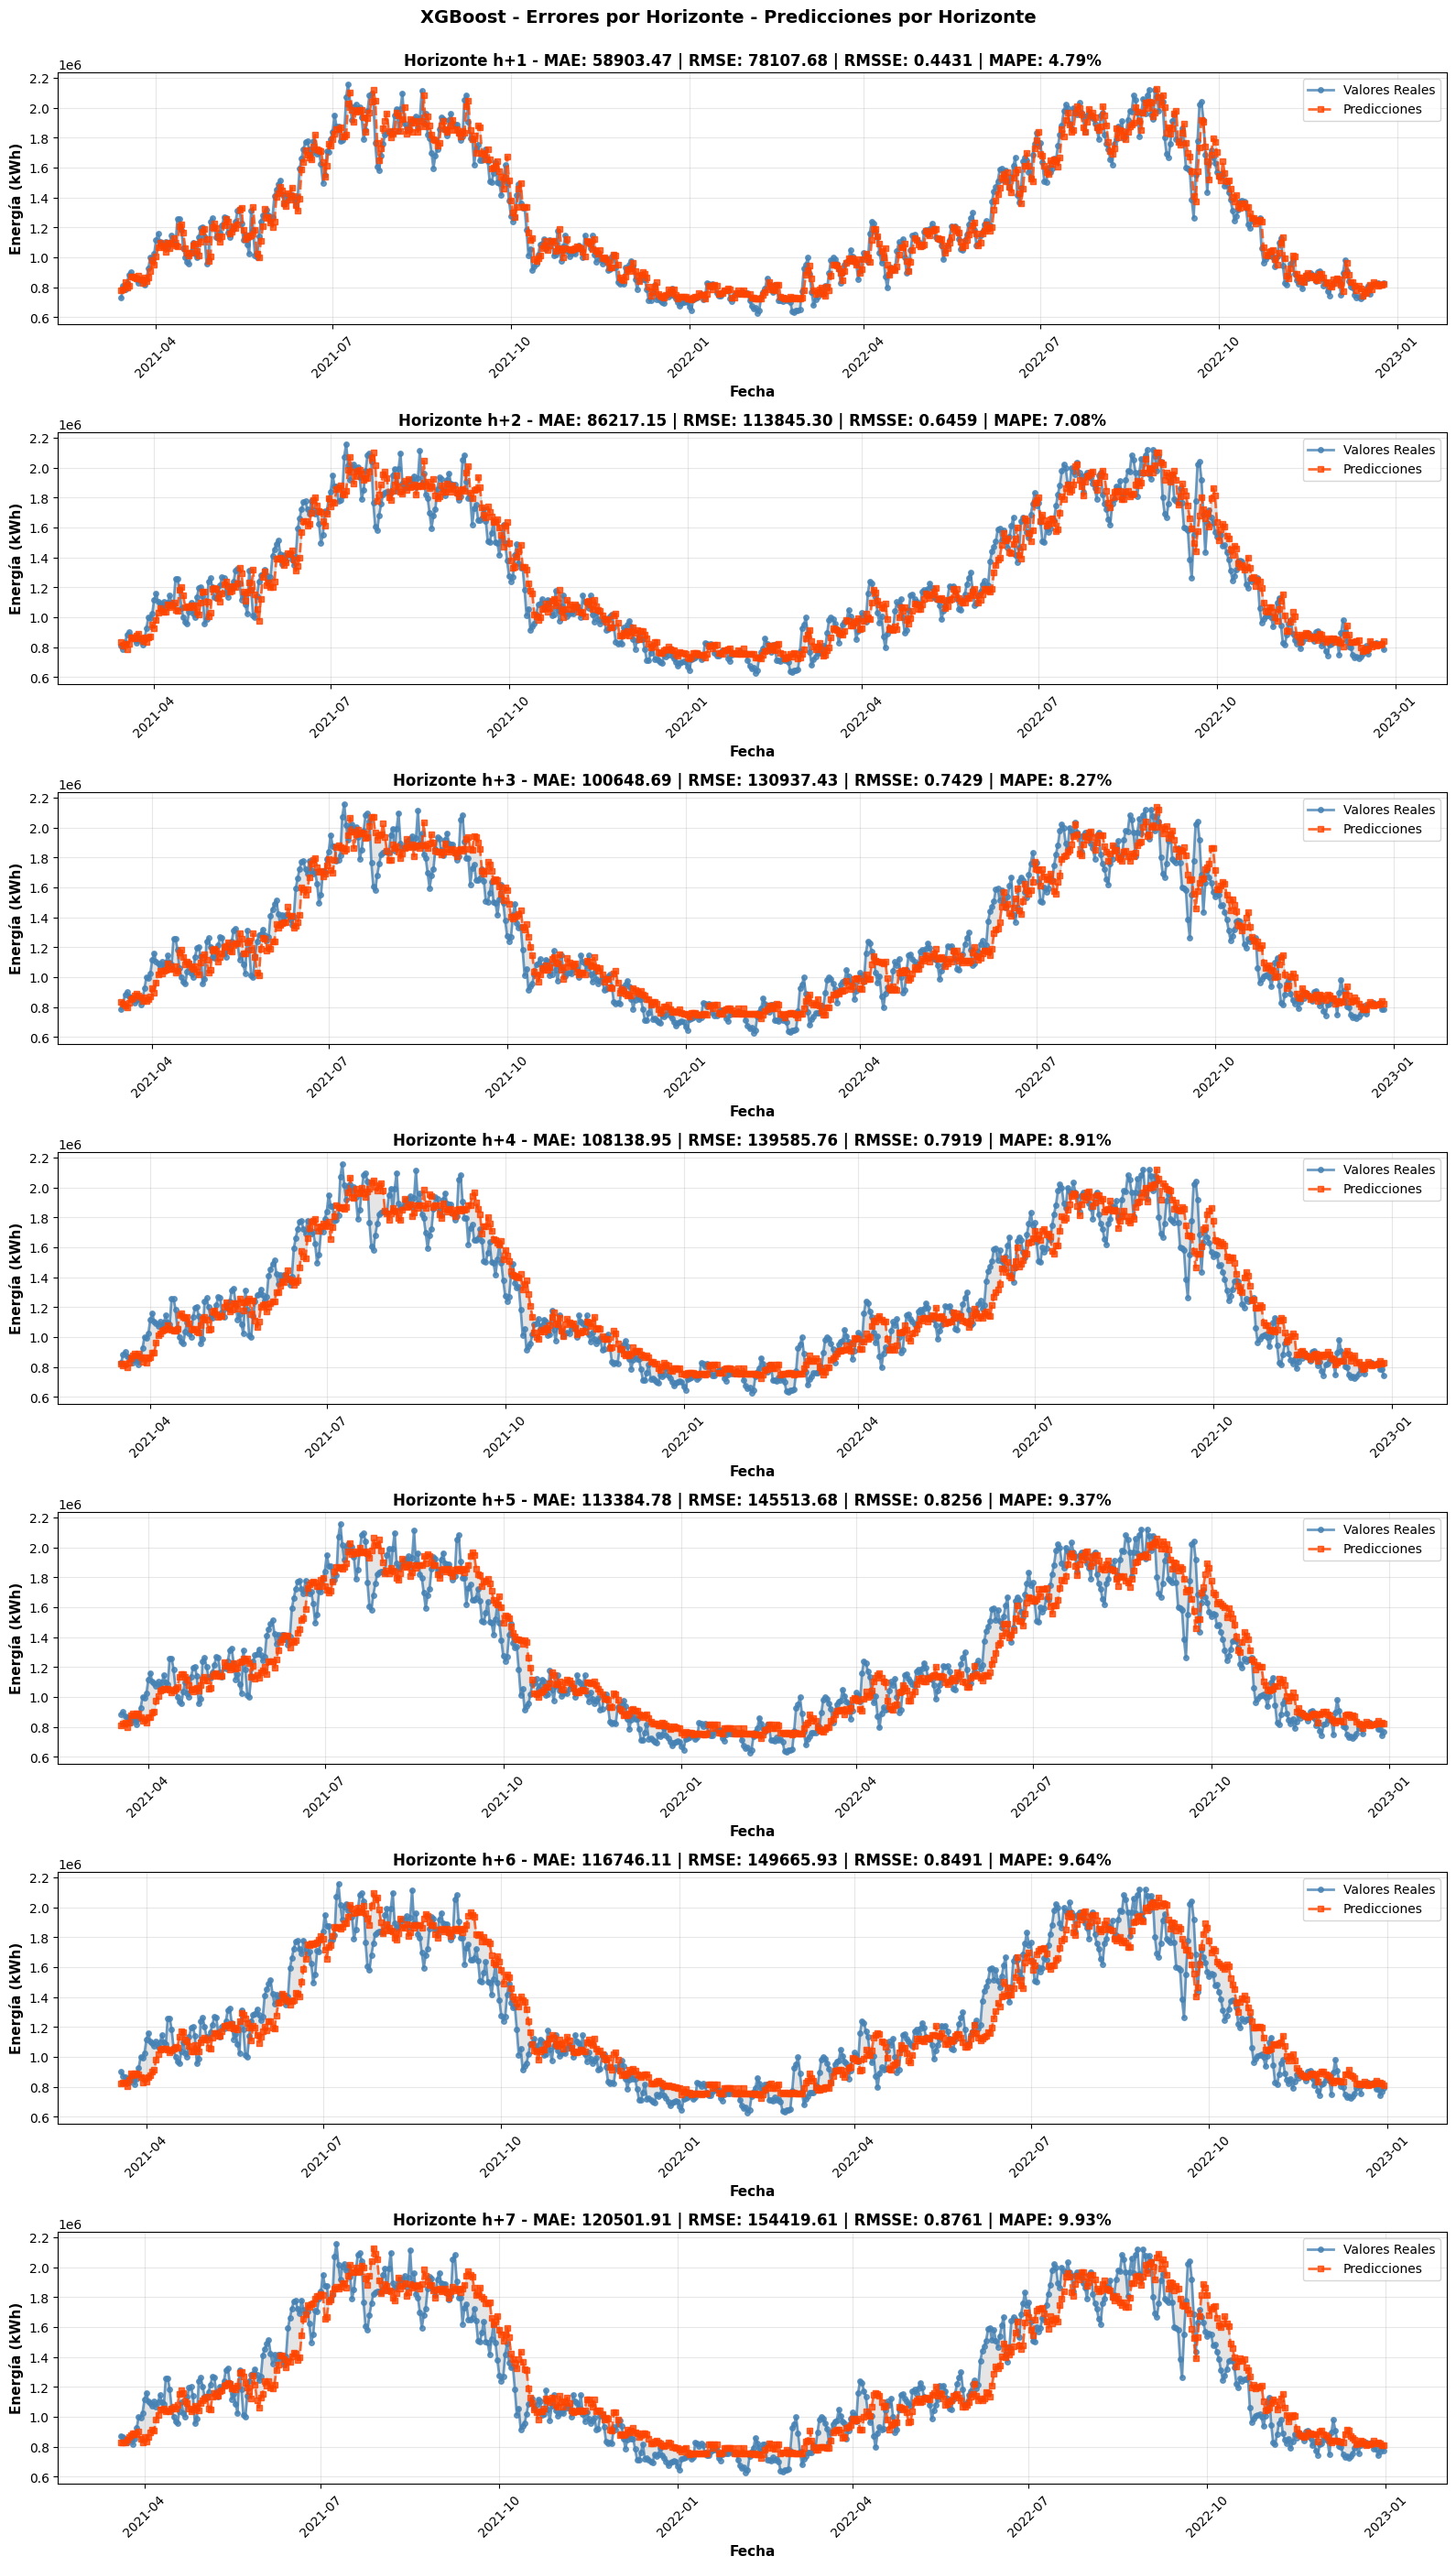

In [28]:
visualizar_errores_horizonte(resultados_xgb, titulo="XGBoost - Errores por Horizonte")

Ahora sí, podemos ver cómo generando las predicciones de esta manera, el modelo se está comportando muy bien. Cuando vamos prediciendo los valores de 1 en 1, las predicciones consecutivas son muy buenas. De esta manera podemos afirmar que nuestro modelo en realidad sí que se comporta muy bien cuando queremos predecir valores en un horizonte temporal de 7 días.

Vemos perfectamente cómo las mejores predicciones son las de los valores h+1, es decir, las del día siguiente al que nos encontramos, obteniendo **un MAE de 58903.47, un RMSE de 78107.68, un RMSSE de 0.4431 y un MAPE del 4.79%**. A medida que se avanza en el horizonte de predicción, vemos cómo se van deteriorandos las métricas obtenidas en cada punto más lejano del conjunto de test. En el valor h+4 obtenemos **un MAE de 108138.95, un RMSE de 139585.76, un RMSSE de 0.7919 y un MAPE del 8.91%**. Al final, para el valor h+7, el último día predicho, obtenemos **un MAE de 120501.91, un RMSE de 154419.61, un RMSSE de 0.8761 y un MAPE del 9.93%.**



Veamos cuáles han sido las métricas de error globales.

In [29]:

resultados_modelos_test.append({'Modelo': 'XGBoost - TEST'} | resultados_xgb['metricas_globales'])

resultados_xgb['metricas_globales']

{'MAE': np.float64(100648.72129286187),
 'RMSE': np.float64(130296.48508861799),
 'RMSSE': np.float64(0.7392206878978852),
 'MAPE': np.float64(8.285780611369114)}

Ahora, observando las métricas globales del modelo, vemos que obtenemos un **MAE del 100648.72**, un **RMSE del 130296.49** , un **RMSSE del 0.7392** y **MAPE del 8.29%**. Valores que son mucho mejores que los anteriores y que nos demuestran que el modelo se comporta muy bien cuando quiere predecir sólo los próximos 7 días siguientes. Además, vemos perfectamente cómo hemos mejorado los resultados del modelo de línea base (que nos daba un MAE del 116176.8626, un RMSE del 150693.5094, un RMSSE del 0.8549 y un MAPE del 9.28%). Veremos cómo se comportan los otros dos modelos.



Por último, hacemos el backtesting de los datos de training.

In [30]:
from skforecast.model_selection import backtesting_forecaster

error, predictions_back = backtesting_forecaster(
                          forecaster            = forecaster_XGB,
                          y                     = energia_train,
                          cv                    = cv,
                          metric                = 'root_mean_squared_scaled_error',
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )

print(f'Raíz del error cuadrático medio escalado (rmsse) en validación: {error['root_mean_squared_scaled_error'][0]:.3f}')



Information of folds
--------------------
Number of observations used for initial training: 730
Number of observations used for backtesting: 1899
    Number of folds: 272
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2015-12-31 00:00:00  (n=730)
    Validation: 2016-01-01 00:00:00 -- 2016-01-07 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2016-01-08 00:00:00 -- 2016-01-14 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2016-01-15 00:00:00 -- 2016-01-21 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2016-01-22 00:00:00 -- 2016-01-28 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2016-01-29 00:00:00 -- 2016-02-04 00:00:00  (n=7)
Fold: 5
    Training:   

100%|██████████| 272/272 [00:00<00:00, 2014.34it/s]


Raíz del error cuadrático medio escalado (rmsse) en validación: 1.417


Tras el backtesting obtenemos un **RMSSE de 1.417** en el conjunto de entrenamiento según las métricas del método. Es mayor que el RMSSE obtenido con el conjunto de test, pero `debemos tener en cuenta que este método no calcula correctamente los errores agregados por cada uno de los días del horizonte, tal y como hacemos nosotros.`

Por esto, calculamos manualmente los errores del backtesting con el método que hemos creado.

In [31]:
y_true_bt_xgb = energia_train.iloc[360*2+10:]  # Ajustar índice para el backtesting
y_pred_bt_xgb = predictions_back['pred']

metricas_xgb = calcular_metricas(
    y_true_bt_xgb,
    y_pred_bt_xgb,
    energia_train.values, 
    nombre_modelo="XGBoost - Backtesting"
)


resultados_modelos_cv.append(metricas_xgb)


Métricas de XGBoost - Backtesting:
  • MAE   = 122040.790 kWh
  • RMSE  = 162434.606 kWh
  • RMSSE = 0.9216
  • MAPE  = 8.94%


Ahora obtenemos un **MAE del 122040.790**, un **RMSE del 162434.606** , un **RMSSE del 0.9216** y un **MAPE del 8.94%**. Son resultados muy similares a los obtenidos anteriormente con test, algo inferiores, pero que parecen bastante correctos. **Podemos descartar que estemos teniendo sobreajuste en nuestro modelo.**

Vemos gráficamente las predicciones del backtesting.

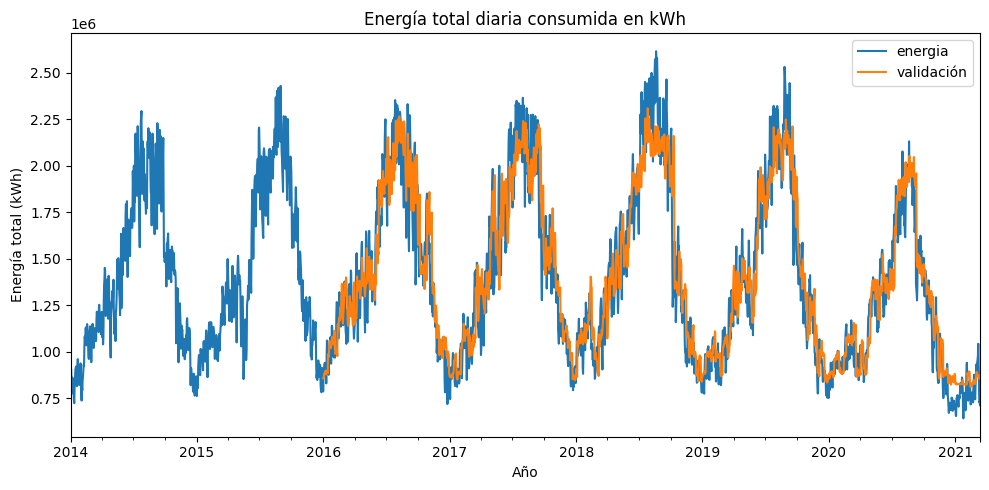

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax)
predictions_back['pred'].plot(ax=ax)
ax.set_xlabel('Año')
ax.set_ylabel('Energía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend(labels=['energia','validación'])
fig.tight_layout()
plt.show()

Vemos que el modelo se comporta también muy bien a la hora de predecir los ejemplos de training. Si observamos la gráfica, las predicciones se ajustan bastante bien a los datos reales.

### Random Forest <a class="anchor" id="random"></a>

Pasamos ahora a entrenar nuestro modelo de Random Forest. Al igual que antes usaremos predicción recursiva.

In [33]:

# Creamos el modelo con predicción recursiva
from sklearn.ensemble import RandomForestRegressor


forecaster_RandomForest = ForecasterRecursive(
                 regressor       = RandomForestRegressor(random_state=123, n_jobs=-1,),
                 lags            = 365, #este valor se sobreecribe en la búsqueda de hiperparámetros
                 differentiation = None
             )

C:\Users\vecto\AppData\Local\Temp\ipykernel_25184\1684553314.py:5: FutureWarning: The `regressor` argument is deprecated and will be removed in a future version. Please use `estimator` instead.
  forecaster_RandomForest = ForecasterRecursive(


Creamos de nuevo el grid de lags con los mismos valores que antes.

Para el grid de hiperparámetros, usamos los valores por defecto y los variamos ligeramente:

* **n_estimators**: escogemos el valor por defecto, 100, y lo vamos aumentando, 200 y 400. Normalmente, cuantos más árboles tengamos más precisa será la predicción pero tendremos más riesgo de overfitting.
* **max_depth**: escogemos los mismos valores que el modelo anterior, pero algo menos profundos (3, 5 y 8) para que sean más fáciles de computar puesto que ahora tendremos muchos más. Usualmente, árboles más profundos son más exactos pero tienen más riesgo de overfitting.


In [34]:
lags_grid = [7, 30, 183 ,365, [1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 364, 365]]

#Creamos el grid de hiperparámetros
param_grid_RandomForest = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3,5, 8],
}


Antes de entrenar el modelo, definimos la técnica de muestreo que usaremos. Usamos 7 steps, puesto que tenemos que predecir los próximos 7 días. Usamos un tamaño inicial de entrenamiento de 730, para incluir los valores de los dos primeros años en el primer entrenamiento del modelo. Cuanto más grande sea este valor, menos pliegues tendremos en la validación cruzada. Consideramos 2 años justos como para tener suficientes datos y no tener demasiados pliegues. No reentrenamos el modelo en cada pliegue. Usamos una ventana de 365 para cada pliegue; usamos ventana deslizante, por lo que el tamaño de entrenamiento siempre es fijo; no usamos gap y permitimos que el último pliegue esté incompleto; y por último, **no usamos diferenciación** porque, como vimos en el análisis de los datos, se trata de una serie estacionaria. 

In [35]:
cv = TimeSeriesFold(
         steps                 = 7,
         initial_train_size    = 730,
         fold_stride           = None,
         window_size           = 365,
         refit                 = False,
         fixed_train_size      = True,
         gap                   = 0,
         allow_incomplete_fold = True,
         differentiation       = None,
         verbose               = False
     )

Pasamos a entrenar nuestro modelo mediante búsqueda de hiperparámetros.

In [36]:
results_grid_RandomForest = grid_search_forecaster(
                   forecaster         = forecaster_RandomForest,
                   y                  = energia_train,
                   param_grid         = param_grid_RandomForest,
                   lags_grid          = lags_grid,
                   cv                 = cv,
                   metric             = 'root_mean_squared_scaled_error',
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

lags grid: 100%|██████████| 5/5 [04:09<00:00, 49.97s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 1.4280282959033324


Vemos que los mejores parámetros son **5** para max_depth y **100** para n_estimators. La métrica de raíz de error cuadrático medio escalado del mejor modelo, según el método, ha sido de **1.43**. `Pero como ya hemos indicado antes, calcularemos manualmente esta métrica posteriormente para hacerlo correctamente.`

Veamos los parámetros del mejor modelo.

In [37]:
forecaster_RandomForest

=================== 
ForecasterRecursive 
=================== 
Estimator: RandomForestRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window features: None 
Window size: 30 
Series name: Energía total (kWh) 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2021-03-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Estimator parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    5, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2026-01-08 02:27:11 
Last fit date: 2026-01-08 02:31:21 
Skforecast version: 0.19.1 
Python version: 3.12.7 
Forecaster id: None


Vemos que ahora el mejor lag es de nuevo 30. Veamos la importancia de los lags en este modelo.

In [38]:
# Vemos la importanca de las características
importance_df =forecaster_RandomForest.get_feature_importances().sort_values(ascending=False, by='importance')
importance_df['importance'] = importance_df['importance'] * 100
    
print(importance_df.head(20).to_string(
    formatters={'importance': '{:.2f}%'.format}
))

   feature importance
0    lag_1     98.67%
6    lag_7      0.49%
5    lag_6      0.33%
19  lag_20      0.07%
12  lag_13      0.06%
13  lag_14      0.04%
27  lag_28      0.03%
7    lag_8      0.03%
1    lag_2      0.03%
4    lag_5      0.02%
21  lag_22      0.02%
20  lag_21      0.02%
22  lag_23      0.02%
28  lag_29      0.02%
11  lag_12      0.02%
2    lag_3      0.01%
29  lag_30      0.01%
3    lag_4      0.01%
10  lag_11      0.01%
18  lag_19      0.01%


En este caso, el modelo le da **una importancia del 98.67% al lag 1**. El lag 7 y el lag 6, obtienen una importancia del 0.49% y el 0.33% respectivamente. Por tanto, sin lugar a dudas, según este modelo el valor más importante para determinar la predicción del día siguiente es el del día anterior. Estos resultados concuerdan totalmente con los arrojados por el modelo baseline, puesto que nos arroja muy buenos resultados teniendo sólo en cuenta este (el día anterior).

Volvemos a hacer las predicciones usando el primer método para ver cómo se comporta este modelo.

In [39]:
predicciones_grid = forecaster_RandomForest.predict(steps=len(energia_test))
predicciones_grid

2021-03-14    730232.889448
2021-03-15    757914.040454
2021-03-16    772329.649654
2021-03-17    788366.237306
2021-03-18    797334.229109
                  ...      
2022-12-27    895709.019154
2022-12-28    895709.019154
2022-12-29    895709.019154
2022-12-30    895709.019154
2022-12-31    895709.019154
Freq: D, Name: pred, Length: 658, dtype: float64

No podemos decir gran cosa a simple vista de estos valores. Comprobamos gráficamente cómo se parecen a los datos reales de test.

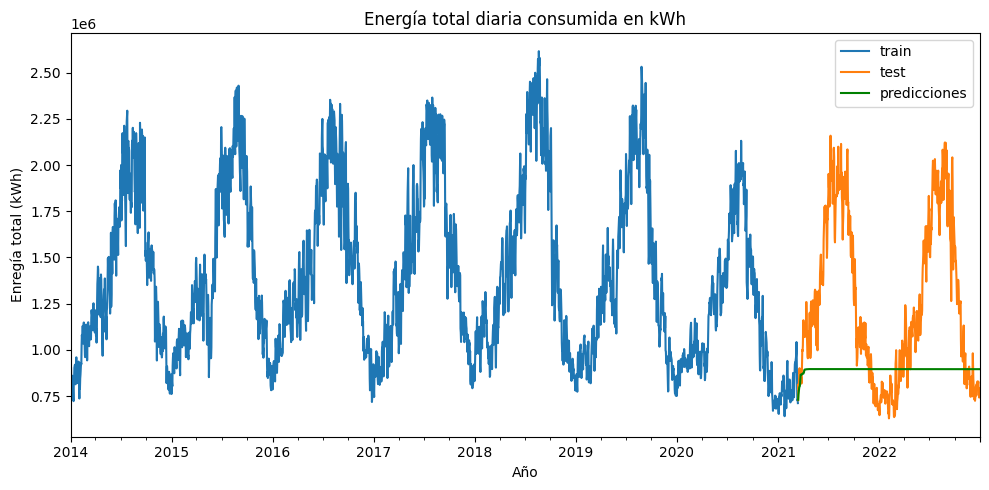

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax, label='train')
energia_test.plot(ax=ax, label='test')
predicciones_grid.plot(ax=ax, label='predicciones', color='green')
ax.set_xlabel('Año')
ax.set_ylabel('Enregía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend()
fig.tight_layout()
plt.show()

Sigue ocurriendo lo mismo que con el anterior modelo: **estamos pidiéndole predecir demasiados valores para un modelo entrenado para un horizonte de 7 días**. Como estamos usando predicción recursiva, los errores en cada predicción se van acumulando poco a poco hasta el punto de que los valores se van estabilizando y se van generando valores iguales. Entonces, esta gráfica no nos está mostrando adecuadamente cómo se comporta nuestro modelo cuando lo que queremos predecir son sólo los próximos 7 días. Como es predicción recursiva, los errores se acumulan y las predicciones se van quedando en torno al mismo valor. **Generamos de nuevo las predicciones con el método alternativo que hemos diseñado.**

In [41]:
resultados_rf = calcular_errores_por_horizonte(
    modelo=forecaster_RandomForest,
    test_data=energia_test,
    train_data=energia_train,  # Añadir esto para tener suficientes lags
    offset_lags=max(forecaster_RandomForest.lags),
    exog_test=None,
    horizonte=7,
    verbose=True
)

resultados_rf

{'metricas_por_horizonte':   Horizonte            MAE           RMSE     RMSSE      MAPE
 0       h+1   58769.469382   78283.567882  0.444132  4.800753
 1       h+2   86353.992545  114552.267778  0.649898  7.087747
 2       h+3  100396.885445  131250.089119  0.744631  8.251538
 3       h+4  108131.737342  141003.559632  0.799966  8.923502
 4       h+5  112974.690098  147435.954977  0.836459  9.323618
 5       h+6  116354.408656  150898.880638  0.856106  9.601252
 6       h+7  120043.374544  154722.906334  0.877801  9.884614,
 'metricas_globales': {'MAE': np.float64(100432.07971588933),
  'RMSE': np.float64(131163.88948007816),
  'RMSSE': np.float64(0.7441417974006069),
  'MAPE': np.float64(8.267574989778344)},
 'errores_detallados':      ventana fecha_inicio        mae_h1        mse_h1   mape_h1        mae_h2  \
 0          0   2021-03-14   1976.772638  3.907630e+06  0.271439  55503.694166   
 1          1   2021-03-15  58436.233987  3.414793e+09  7.184037  13632.988826   
 2          

A simple vista no podemos decir nada de estos resultados. Veamos gráficamente la comparación con los datos reales de test.

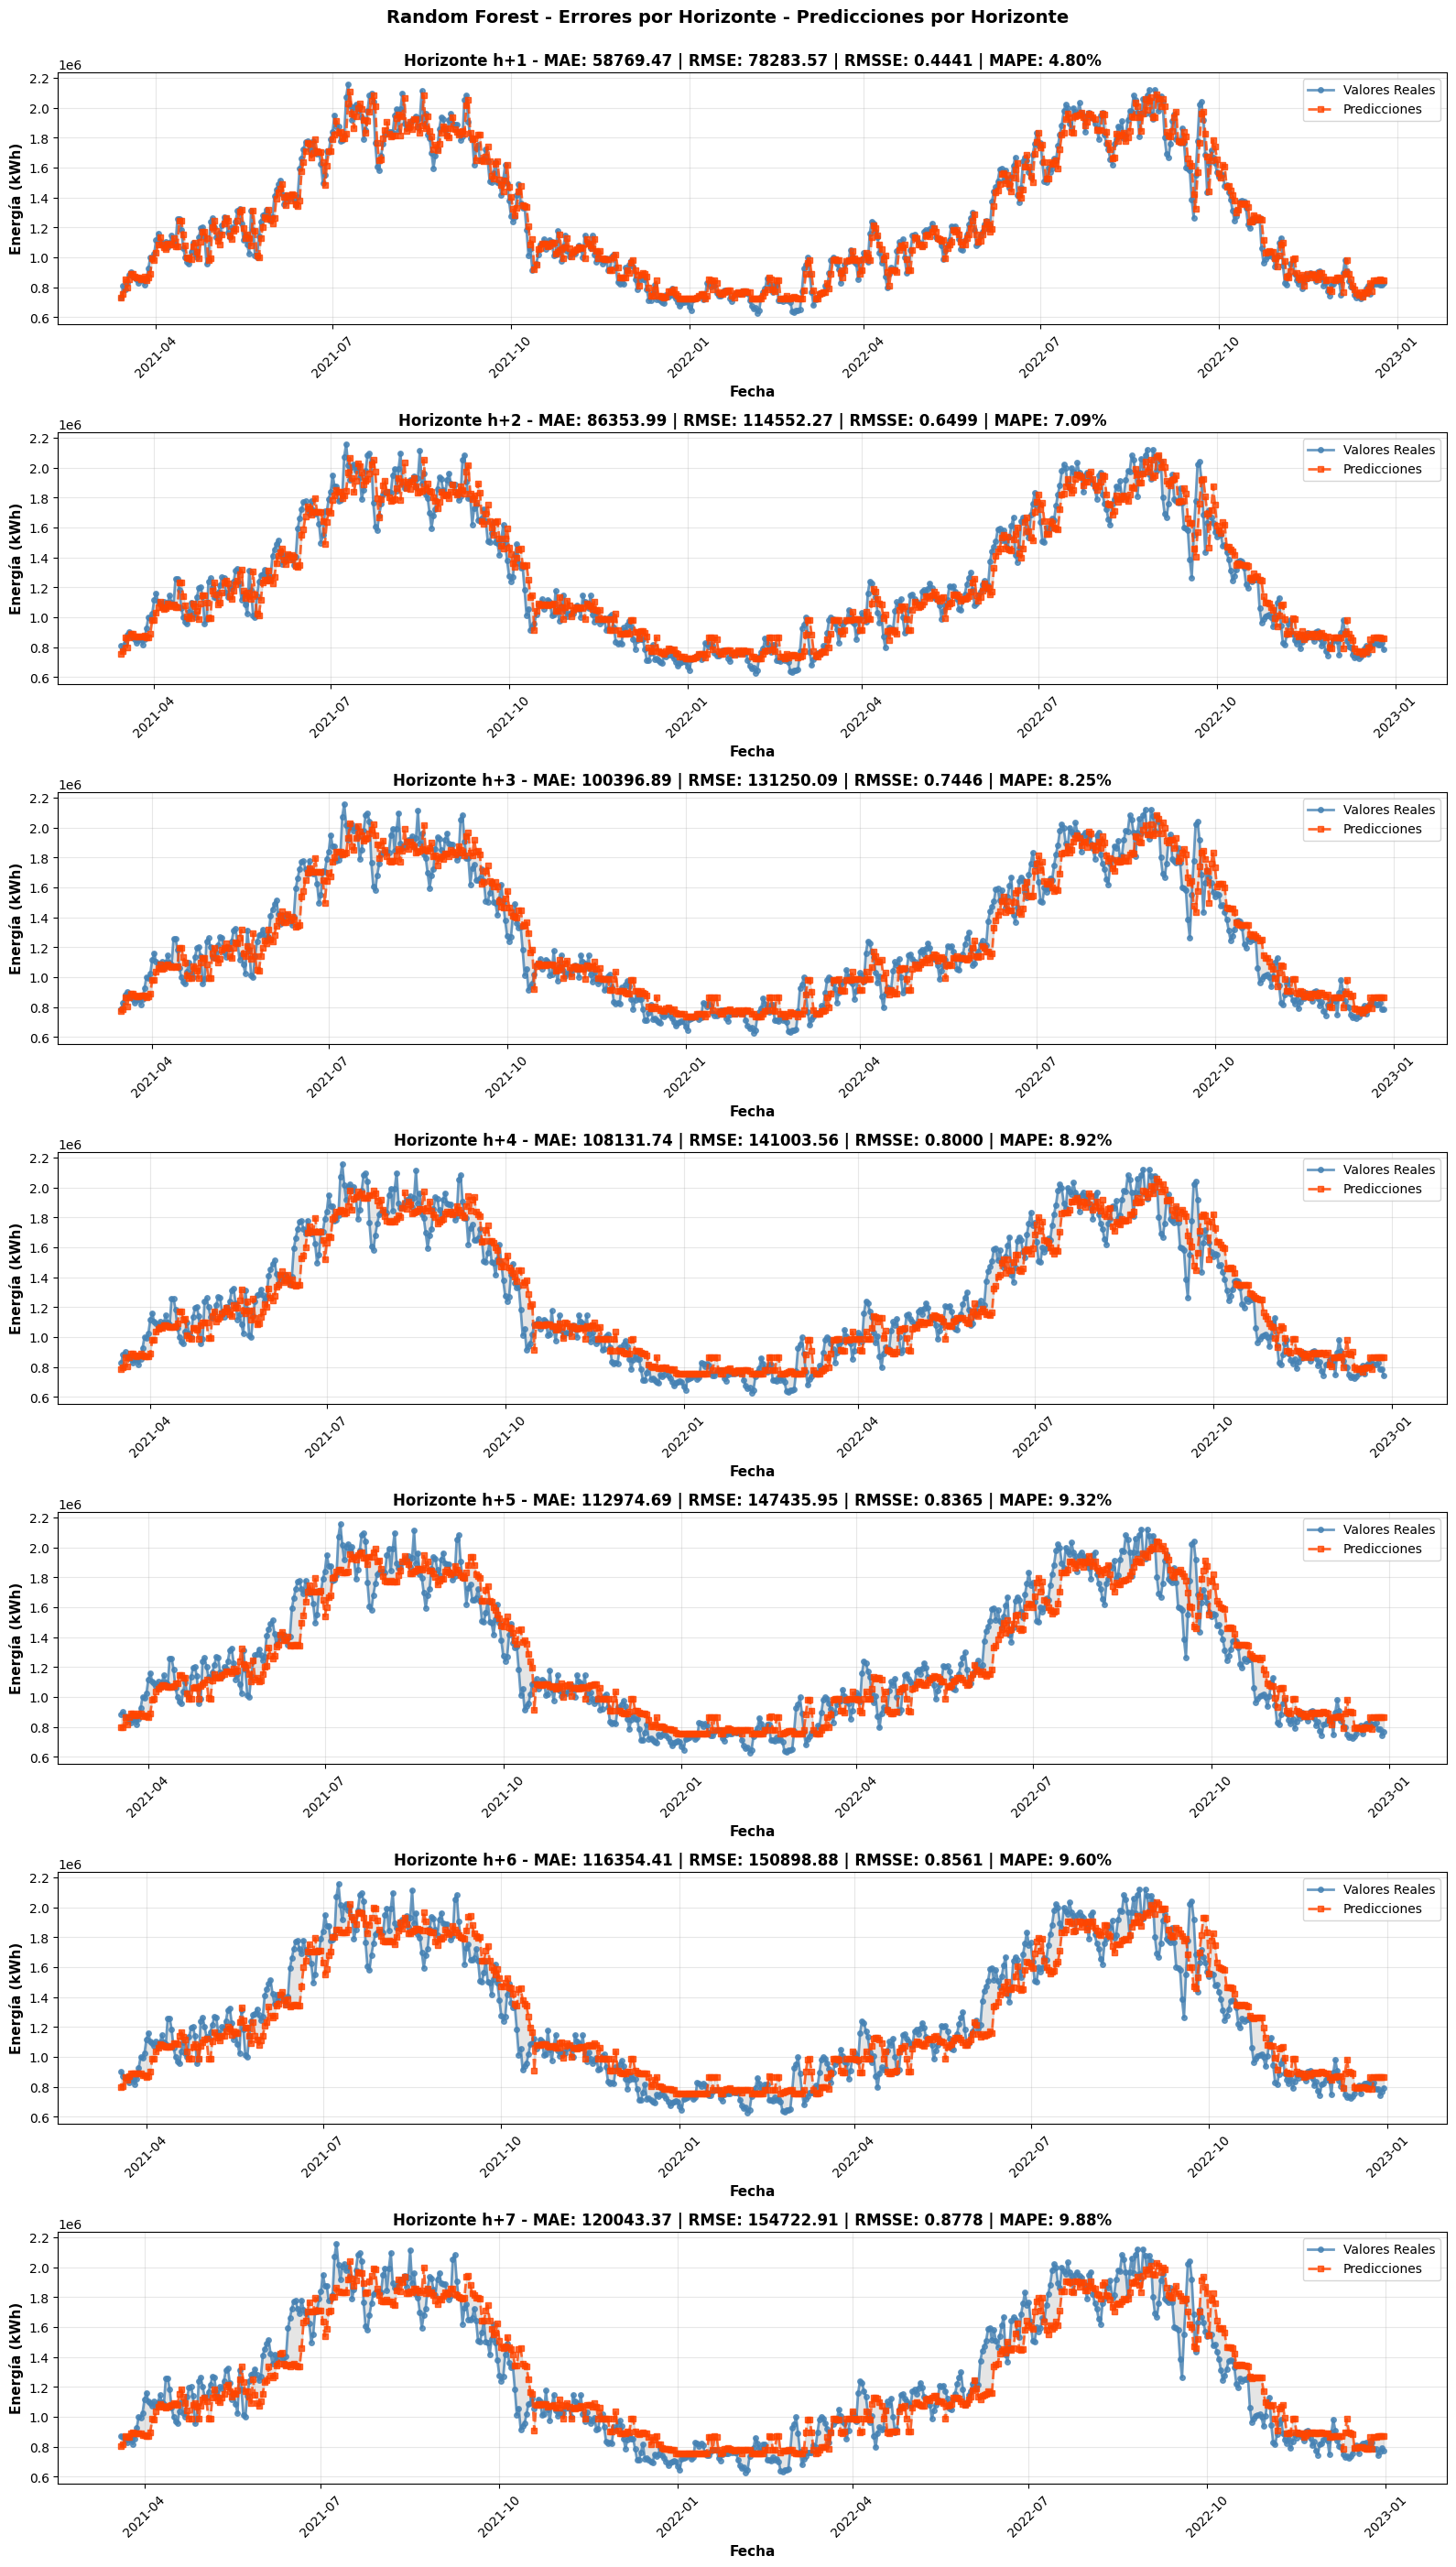

In [42]:
visualizar_errores_horizonte(resultados_rf, titulo="Random Forest - Errores por Horizonte")

Ahora sí, podemos ver cómo generando las predicciones de esta manera, el modelo se está comportando muy bien. Cuando vamos prediciendo los valores de 1 en 1, las predicciones consecutivas son muy buenas. De esta manera podemos afirmar que nuestro modelo en realidad sí que se comporta muy bien cuando queremos predecir valores en un horizonte temporal de 7 días.

Vemos perfectamente cómo las mejores predicciones son las de los valores h+1, es decir, las del día siguiente al que nos encontramos, obteniendo **un MAE de 58769.47, un RMSE de  78283.57, un RMSSE de 0.4441 y un MAPE del 4.80%**. A medida que se avanza en el horizonte de predicción, vemos cómo se van deteriorandos las métricas obtenidas en cada punto más lejano del conjunto de test. En el valor h+4 obtenemos **un MAE de 108131.74, un RMSE de 141003.56, un RMSSE de 0.79997 y un MAPE del 8.92%**. Al final, para el valor h+7, el último día predicho, obtenemos **un MAE de 120043.37, un RMSE de 154722.91, un RMSSE de 0.8778 y un MAPE del 9.88%.**


 
Veamos cuáles han sido las métricas de error globales.

In [43]:

resultados_modelos_test.append({'Modelo': 'RandomForest - TEST'} | resultados_rf['metricas_globales'])

resultados_rf['metricas_globales']

{'MAE': np.float64(100432.07971588933),
 'RMSE': np.float64(131163.88948007816),
 'RMSSE': np.float64(0.7441417974006069),
 'MAPE': np.float64(8.267574989778344)}

Ahora, observando las métricas globales del modelo, podemos ver que obtenemos un **MAE del 100432.080**, un **RMSE del 131163.889** , un **RMSSE del 0.744** y un **MAPE del 8.27%**. Valores que nos demuestran que el modelo se comporta muy bien cuando quiere predecir sólo los próximos 7 días siguientes. Parecen bastantes similares a los arrojados por el modelo XGBoost. Además, vemos que volvemos a mejorar los resultados del modelo de línea base (que nos daba un MAE del 116176.8626, un RMSE del 150693.5094, un RMSSE del 0.8549 y un MAPE del 9.28%). Ya veremos cómo se comporta el último modelo. 

Por último hacemos el backtesting de los datos de training.

In [44]:
error, predictions_back = backtesting_forecaster(
                          forecaster            = forecaster_RandomForest,
                          y                     = energia_train,
                          cv                    = cv,
                          metric                = 'root_mean_squared_scaled_error',
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )

print(f'Raíz del error cuadrático medio escalado (rmsse) en validación: {error['root_mean_squared_scaled_error'][0]:.3f}')



Information of folds
--------------------
Number of observations used for initial training: 730
Number of observations used for backtesting: 1899
    Number of folds: 272
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2015-12-31 00:00:00  (n=730)
    Validation: 2016-01-01 00:00:00 -- 2016-01-07 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2016-01-08 00:00:00 -- 2016-01-14 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2016-01-15 00:00:00 -- 2016-01-21 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2016-01-22 00:00:00 -- 2016-01-28 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2016-01-29 00:00:00 -- 2016-02-04 00:00:00  (n=7)
Fold: 5
    Training:   

100%|██████████| 272/272 [00:01<00:00, 137.80it/s]


Raíz del error cuadrático medio escalado (rmsse) en validación: 1.428


Tras el backtesting obtenemos un **RMSSE de 1.428** en el conjunto de entrenamiento. Sin embargo, como hemos dicho antes, no creemos que el método esté calculando correctamente este error. Al menos, no tal y como lo hemos planteado aquí. Pasamos a calcular manualmente los errores del backtesting. 


In [45]:
y_true_bt_rf = energia_train.iloc[360*2+10:]  # Ajustar índice para el backtesting
y_pred_bt_rf = predictions_back['pred']

metricas_rf = calcular_metricas(
    y_true_bt_rf,
    y_pred_bt_rf,
    energia_train.values, 
    nombre_modelo="RandomForest - Backtesting"
)


resultados_modelos_cv.append(metricas_rf)


Métricas de RandomForest - Backtesting:
  • MAE   = 124780.665 kWh
  • RMSE  = 163750.564 kWh
  • RMSSE = 0.9290
  • MAPE  = 9.42%


Ahora vemos que obtenemos un **MAE del 124780.665**, un **RMSE del 163750.564** , un **RMSSE del 0.9290** y un **MAPE del 9.42%**. Son resultados muy similares a los obtenidos anteriormente con test, algo inferiores, pero que parecen bastante correctos. **Podemos descartar que estemos teniendo sobreajuste en nuestro modelo.**

Vemos gráficamente las predicciones del backtesting.

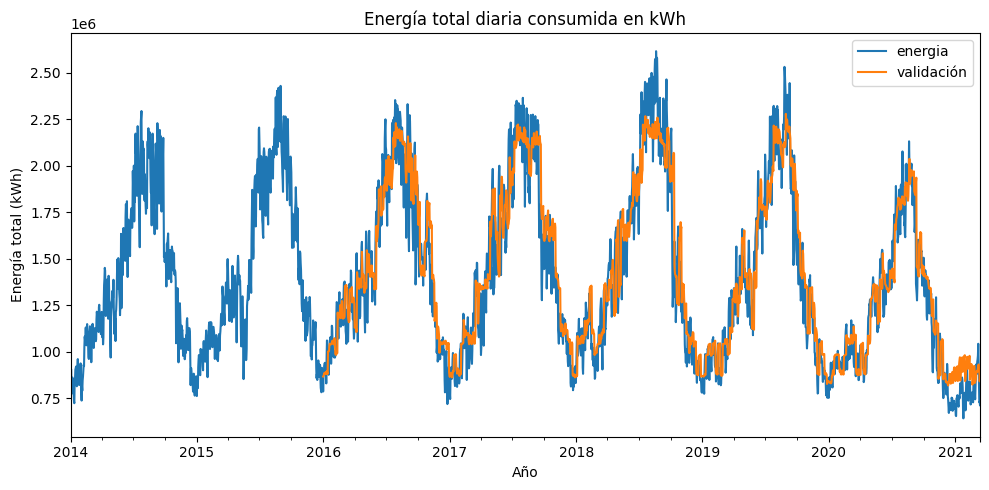

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax)
predictions_back['pred'].plot(ax=ax)
ax.set_xlabel('Año')
ax.set_ylabel('Energía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend(labels=['energia','validación'])
fig.tight_layout()
plt.show()



Vemos que el modelo de Random Forest también predice muy bien los casos de training. Si observamos la gráfica, las predicciones se ajustan bastante bien a los datos reales.

### SVR <a class="anchor" id="svr"></a>

Entrenamos, por último, nuestro modelo de SVR ajustándolo mediante grid de hiperparámetros. Volvemos a usar predicción recursiva. **Debemos tener en cuenta, que las máquinas de soporte vectorial necesitan tener los datos normalizados para que su funcionamiento sea correcto y adecuado. Por tanto, usamos normalización estándar como función de transformación en nuestro modelo.** 

In [47]:
# Creamos el modelo con predicción recursiva, teniendo en cuenta el escalado de los datos
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


forecaster_SVR = ForecasterRecursive(
                 regressor       = SVR(),
                 lags            = 365, #este valor se sobreecribe en la búsqueda de hiperparámetros
                 differentiation = None,
                 transformer_y = StandardScaler() # Escalamos los datos de la serie
             )

C:\Users\vecto\AppData\Local\Temp\ipykernel_25184\1139421295.py:6: FutureWarning: The `regressor` argument is deprecated and will be removed in a future version. Please use `estimator` instead.
  forecaster_SVR = ForecasterRecursive(


Creamos de nuevo el grid de lags con los mismos valores que antes. Creamos nuestro grid para el SVR incluyendo los valores por defecto del método.

Para el grid de hiperparámetros, usamos los valores por defecto y los variamos ligeramente:

* **C**: Es un parámetro de regulariación. Escogemos el valor por defecto, 1.0, y lo aumentamos y disminuimos por 10, 0.1 y 10. Este valor debe ser positivo y establece de manera inversamente proporcional la fuerza de la regularización.
* **epsilon**: Establece la penalización para la función de pérdida. Escogemos el valor por defecto y lo aumentamos y disminuimos, con los valores 0.01 y 0.5.
* **kernel**: Tipo de kernel usado por el algoritmo. Usamos el predeterminado.
* **gamma**: Coeficiente para el kernel del algoritmo. Usamos el valor por defecto, 'scale', y dos valores float pequeños, 0.1 y 0.01.

In [48]:
lags_grid = [7, 30, 183 ,365, [1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 364, 365]]

#Creamos el grid de hiperparámetros
param_grid_SVR = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01, 0.1]
}


Antes de entrenar el modelo, definimos la técnica de muestreo que usaremos. Usamos 7 steps, puesto que tenemos que predecir los próximos 7 días. Usamos un tamaño inicial de entrenamiento de 730, para incluir los valores de los dos primeros años en el primer entrenamiento del modelo. Cuanto más grande sea este valor, menos pliegues tendremos en la validación cruzada. Consideramos 2 años justos como para tener suficientes datos y no tener demasiados pliegues. No reentrenamos el modelo en cada pliegue. Usamos una ventana de 365 para cada pliegue; usamos ventana deslizante, por lo que el tamaño de entrenamiento siempre es fijo; no usamos gap y permitimos que el último pliegue esté incompleto; y por último, **no usamos diferenciación** porque, como vimos en el análisis de los datos, se trata de una serie estacionaria. 

In [49]:
cv = TimeSeriesFold(
         steps                 = 7,
         initial_train_size    = 730,
         fold_stride           = None,
         window_size           = 365,
         refit                 = False,
         fixed_train_size      = True,
         gap                   = 0,
         allow_incomplete_fold = True,
         differentiation       = None,
         verbose               = False
     )

Pasamos a entrenar el modelo con el grid de hiperpárametros.

In [50]:
results_grid_SVR = grid_search_forecaster(
                   forecaster         = forecaster_SVR,
                   y                  = energia_train,
                   param_grid         = param_grid_SVR,
                   lags_grid          = lags_grid,
                   cv                 = cv,
                   metric             = 'root_mean_squared_scaled_error',
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

lags grid: 100%|██████████| 5/5 [00:33<00:00,  6.62s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
  Backtesting metric: 1.3951987868872766


Vemos que los mejores parámetros son **1** para la variable C, **0.1** para epsilon y el valor **0.01** para la variable gamma. La métrica de raíz de error cuadrático medio escalado del mejor modelo ha sido de **1.395**. Sin embargo, como ya hemos aclarado, debemos recalcular esta métrica puesto que el método no lo hace correctamente.

Veamos los parámetros del mejor modelo.

In [51]:
forecaster_SVR

=================== 
ForecasterRecursive 
=================== 
Estimator: SVR 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window features: None 
Window size: 30 
Series name: Energía total (kWh) 
Exogenous included: False 
Exogenous names: None 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2021-03-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Estimator parameters: 
    {'C': 1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma':
    0.01, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001,
    'verbose': False} 
fit_kwargs: {} 
Creation date: 2026-01-08 02:32:47 
Last fit date: 2026-01-08 02:33:21 
Skforecast version: 0.19.1 
Python version: 3.12.7 
Forecaster id: None

Vemos que de nuevo el mejor lag es **30**. Pasamos a hacer las predicciones de los datos de test directamente con el método que hemos diseñado. Es decir, calculamos los 7 valores del horizonte para cada uno de los datos de test.

In [52]:
resultados_svr = calcular_errores_por_horizonte(
    modelo=forecaster_SVR,
    test_data=energia_test,
    train_data=energia_train,  # Añadir esto para tener suficientes lags
    offset_lags=max(forecaster_SVR.lags),
    exog_test=None,
    horizonte=7,
    verbose=True
)

resultados_svr

{'metricas_por_horizonte':   Horizonte            MAE           RMSE     RMSSE       MAPE
 0       h+1   55459.258608   72835.545033  0.413223   4.599518
 1       h+2   82555.015308  107558.241258  0.610218   6.910154
 2       h+3   98223.164306  125305.491038  0.710905   8.248087
 3       h+4  106118.918604  135109.095284  0.766524   8.952394
 4       h+5  111446.274398  141828.407067  0.804646   9.408157
 5       h+6  116328.547064  147220.322955  0.835236   9.793577
 6       h+7  120435.795354  152416.623556  0.864717  10.120433,
 'metricas_globales': {'MAE': np.float64(98652.42480600641),
  'RMSE': np.float64(126039.10374138577),
  'RMSSE': np.float64(0.7150669713490146),
  'MAPE': np.float64(8.290331599916238)},
 'errores_detallados':      ventana fecha_inicio        mae_h1        mse_h1   mape_h1        mae_h2  \
 0          0   2021-03-14  45869.695020  2.104029e+09  6.298566  27699.376026   
 1          1   2021-03-15   3201.471040  1.024942e+07  0.393583  53293.585110   
 2   

A simple vista no podemos decir nada de los resultaods. Pasamos a ver la comparación visual de forma gráfica.

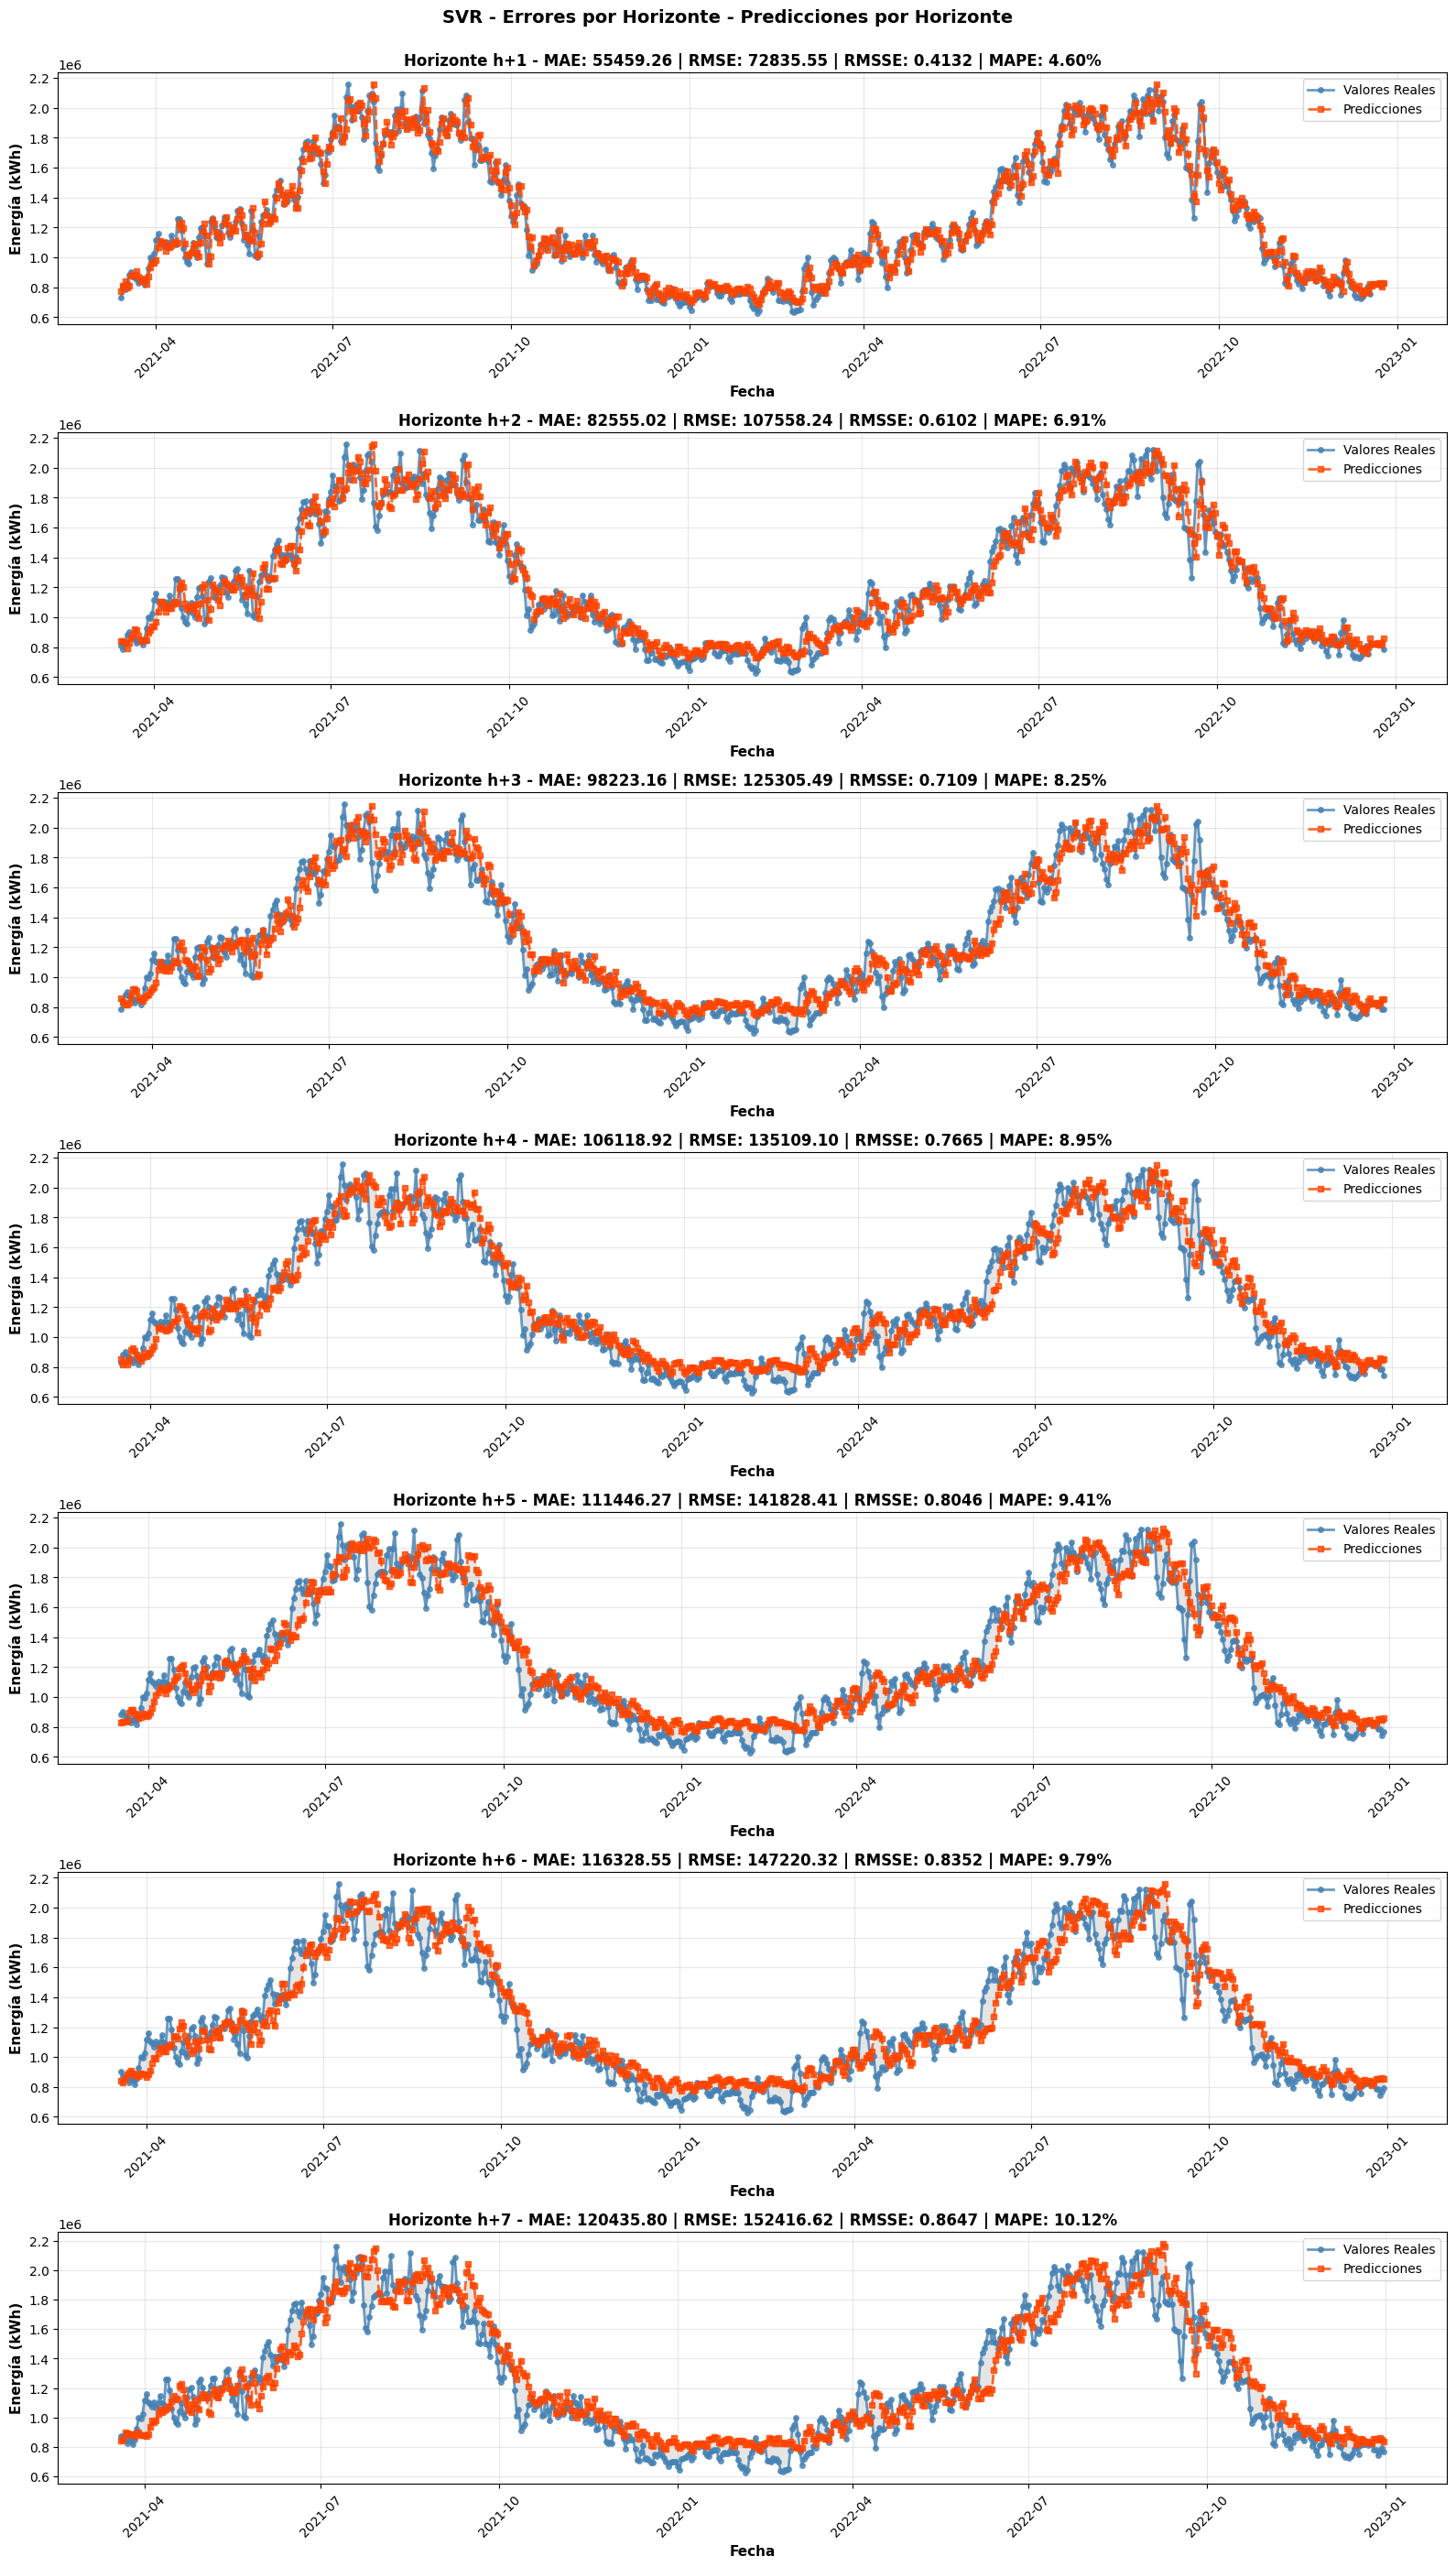

In [53]:
visualizar_errores_horizonte(resultados_svr, titulo="SVR - Errores por Horizonte")

Ahora sí, podemos ver cómo generando las predicciones de esta manera, el modelo se está comportando muy bien. Cuando vamos prediciendo los valores de 1 en 1, las predicciones consecutivas son muy buenas. De esta manera podemos afirmar que nuestro modelo en realidad sí que se comporta muy bien cuando queremos predecir valores en un horizonte temporal de 7 días.

Vemos perfectamente cómo las mejores predicciones son las de los valores h+1, es decir, las del día siguiente al que nos encontramos, obteniendo **un MAE de 55459.26, un RMSE de  72835.55, un RMSSE de 0.4132 y un MAPE del 4.60%**. A medida que se avanza en el horizonte de predicción, vemos cómo se van deteriorandos las métricas obtenidas en cada punto más lejano del conjunto de test. En el valor h+4 obtenemos un **MAE de 106118.92, un RMSE de 135109.095, un RMSSE de 0.7665 y un MAPE del 8.95%**. Al final, para el valor h+7, el último día predicho, obtenemos **un MAE de 120435.80, un RMSE de 152416.62, un RMSSE de 0.8647 y un MAPE del 10.12%.**


Veamos cuáles han sido las métricas de error globales.

In [54]:
resultados_modelos_test.append({'Modelo': 'SVR - TEST'} | resultados_svr['metricas_globales'])

resultados_svr['metricas_globales']

{'MAE': np.float64(98652.42480600641),
 'RMSE': np.float64(126039.10374138577),
 'RMSSE': np.float64(0.7150669713490146),
 'MAPE': np.float64(8.290331599916238)}

Ahora, generando las predicciones de esta manera, vemos que obtenemos un **MAE del 98652.425**, un **RMSE del 126039.104** , un **RMSSE del  0.715** y un **MAPE del 8.29%**. Estos resultados nos demuestran que el modelo se comporta muy bien cuando quiere predecir sólo los próximos 7 días siguientes. Parecen datos bastantes similares a los arrojados por los dos modelos anteriores, es posible que algo mejores en cuanto a RMSSE. Volvemos a ver que se mejoran los resultados del modelo de línea base (que nos daba un MAE del 116176.8626, un RMSE del 150693.5094, un RMSSE del 0.8549 y un MAPE del 9.28%). `En el próximo apartado haremos una comparación entre los 4 modelos.`

Por último, hacemos el backtesting de los datos de training para ver si hay overfitting.

In [55]:
error, predictions_back = backtesting_forecaster(
                          forecaster            = forecaster_SVR,
                          y                     = energia_train,
                          cv                    = cv,
                          metric                = 'root_mean_squared_scaled_error',
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )

print(f'Raíz del error cuadrático medio escalado (rmsse) en validación: {error['root_mean_squared_scaled_error'][0]:.3f}')

Information of folds
--------------------
Number of observations used for initial training: 730
Number of observations used for backtesting: 1899
    Number of folds: 272
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2015-12-31 00:00:00  (n=730)
    Validation: 2016-01-01 00:00:00 -- 2016-01-07 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2016-01-08 00:00:00 -- 2016-01-14 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2016-01-15 00:00:00 -- 2016-01-21 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2016-01-22 00:00:00 -- 2016-01-28 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2016-01-29 00:00:00 -- 2016-02-04 00:00:00  (n=7)
Fold: 5
    Training:   

100%|██████████| 272/272 [00:00<00:00, 2518.00it/s]


Raíz del error cuadrático medio escalado (rmsse) en validación: 1.395


Tras el backtesting obtenemos un **RMSSE de 1.395** en el conjunto de entrenamiento. Sin embargo, como ya hemos explicado, este método no está calculando esta métrica como debería. Pasamos a calcular las métricas manualmente.


In [56]:
y_true_bt_svr = energia_train.iloc[360*2+10:]  # Ajustar índice para el backtesting
y_pred_bt_svr = predictions_back['pred']

metricas_svr = calcular_metricas(
    y_true_bt_svr,
    y_pred_bt_svr,
    energia_train.values, 
    nombre_modelo="SVR - Backtesting"
)


resultados_modelos_cv.append(metricas_svr)


Métricas de SVR - Backtesting:
  • MAE   = 120938.932 kWh
  • RMSE  = 159986.037 kWh
  • RMSSE = 0.9077
  • MAPE  = 8.98%


Ahora vemos que obtenemos un **MAE del 120938.932**, un **RMSE del 159986.037** , un **RMSSE del 0.9077** y un **MAPE del 8.98%**. Ahora sí obtenemos unas métricas correctas. Son resultados muy similares a los obtenidos anteriormente con test, algo inferiores, pero que parecen bastante correctos. **Podemos descartar que estemos teniendo sobreajuste en nuestro modelo.**

Vemos gráficamente las predicciones del backtesting.

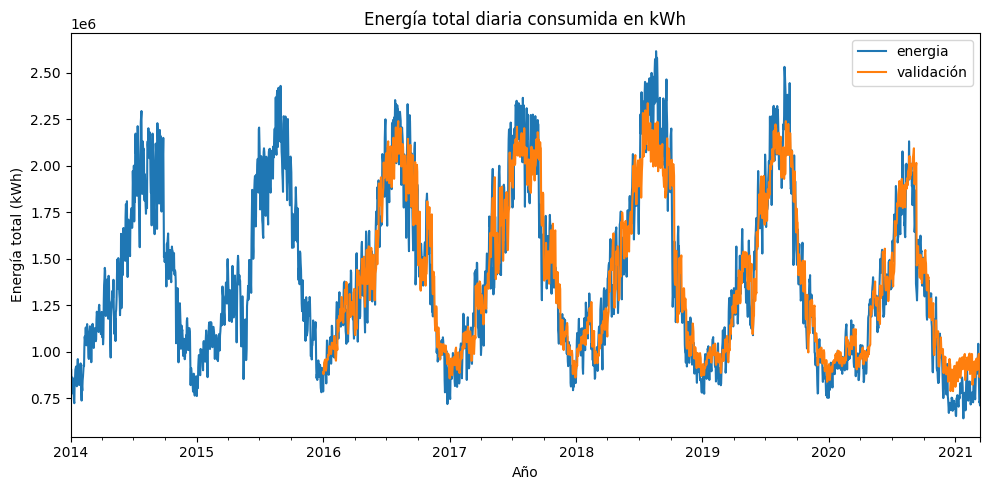

In [57]:
fig, ax = plt.subplots(figsize=(10, 5))
energia_train.plot(ax=ax)
predictions_back['pred'].plot(ax=ax)
ax.set_xlabel('Año')
ax.set_ylabel('Energía total (kWh)')
ax.set_title('Energía total diaria consumida en kWh')
ax.legend(labels=['energia','validación'])
fig.tight_layout()
plt.show()

Vemos que el modelo de SVR también predice muy bien los casos de training. Si observamos la gráfica, las predicciones se ajustan bastante bien a los datos reales.

## Comparación de modelos y conclusiones <a class="anchor" id="conclu"></a>

Ahora compararemos los resultados obtenidos por cada uno de nuestros modelos.  `Prestaremos especial atención al RMSSE y al MAPE, puesto que consideramos que son las métricas que mejores nos permiten identificar al modelo con mejor rendimiento. Creemos que son las más informativas por ser independientes a escala y ser fácilmente interpretables.`

Nos centraremos primero en la predicción de los datos de entrenamiento obtenida durante el backtesting.

In [58]:
# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados_modelos_cv)
df_resultados = df_resultados.sort_values('MAE')

print("\nTABLA DE RESULTADOS (ordenado por MAE):")
print("\n" + df_resultados.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_mae = df_resultados[df_resultados['Modelo'] == 'Baseline Simple - TRAIN (media horizontes)']['MAE'].values[0]
mejor_mae = df_resultados.iloc[0]['MAE']
mejora = ((baseline_mae - mejor_mae) / baseline_mae) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en MAE")

display(df_resultados.style.background_gradient(subset=['MAE', 'RMSSE','RMSE','MAPE'], cmap='RdYlGn_r')
                          .format({'MAE': '{:.3f}', 'RMSE': '{:.4f}', 'RMSSE': '{:.4f}', 'MAPE': '{:.2f}%'}))


TABLA DE RESULTADOS (ordenado por MAE):

                                    Modelo           MAE          RMSE    RMSSE      MAPE
                         SVR - Backtesting 120938.931674 159986.037123 0.907661  8.978475
                     XGBoost - Backtesting 122040.790329 162434.605708 0.921552  8.942352
                RandomForest - Backtesting 124780.665251 163750.563797 0.929018  9.417951
Baseline Simple - TRAIN (media horizontes) 156241.744542 202863.745634 1.150922 11.843202

Mejora respecto al baseline: 22.59% en MAE


En esta primera comparación, si nos fijamos en la predicción de los datos de entrenamiento, podemos ver el potencial del modelo SVR. Este es el que mejores resultados nos ofrece para todas las métricas. En cuanto a los tres modelos principales, podemos ver que SVR nos da unos mejores resultados sobre los otros dos en todas las métricas menos en MAPE, en el que XGBoost nos da una medida ligeramente mejor. Vemos que Random Forest es el que peor se comporta de los tres. Por último, como esperábamos, el modelo baseline es el peor de todos.

Sin embargo, **para realizar la comparación definitiva, nos centraremos en la predicción que realizan nuestros modelos para el conjunto de test**. Este será la comparación clave en la que determinaremos cuál de los modelos es mejor a la hora de predecir nuevos datos futuros.

In [59]:
# Crear DataFrame con resultados
df_resultados_test = pd.DataFrame(resultados_modelos_test)
df_resultados_test = df_resultados_test.sort_values('MAE')

print("\nTABLA DE RESULTADOS (ordenado por MAE):")
print("\n" + df_resultados_test.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados_test.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_mae = df_resultados_test[df_resultados_test['Modelo'] == 'Baseline Simple - TEST (media horizontes)']['MAE'].values[0]
mejor_mae = df_resultados_test.iloc[0]['MAE']
mejora = ((baseline_mae - mejor_mae) / baseline_mae) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en MAE")

display(df_resultados_test.style.background_gradient(subset=['MAE', 'RMSSE','RMSE','MAPE'], cmap='RdYlGn_r')
                          .format({'MAE': '{:.3f}', 'RMSE': '{:.4f}', 'RMSSE': '{:.4f}', 'MAPE': '{:.2f}%'}))


TABLA DE RESULTADOS (ordenado por MAE):

                                   Modelo           MAE          RMSE    RMSSE     MAPE
                               SVR - TEST  98652.424806 126039.103741 0.715067 8.290332
                      RandomForest - TEST 100432.079716 131163.889480 0.744142 8.267575
                           XGBoost - TEST 100648.721293 130296.485089 0.739221 8.285781
Baseline Simple - TEST (media horizontes) 116176.862562 150693.509386 0.854941 9.281418

Mejora respecto al baseline: 15.08% en MAE


Vemos cómo para todas las métricas, sin ningún tipo de dudas, el `modelo SVR resulta el mejor de todos.` `Hemos conseguido, además, lograr el objetivo que nos impusimos de intentar mejorar los resultados del modelo baseline con los tres modelos principiales.` Con este modelo conseguimos `un MAE de 98652.42, un RMSE de 126039.10, un RMSSE de 0.7151 y un MAPE del 8.29%.`

El resto de modelos (sin incluir el baseline) nos dan unos resultados algo similares pero peores, siendo SVR el que mejores métricas nos ofrece para RMSSE y RandomForest, el que peores. Las métricas de RandomForest destacan un poco sobre las de los otros dos modelos en cuanto a el MAPE. Sin embargo, al ser esta medida muy parecida a la de los otros dos, y tener SVR mejores resultados en todas las demás métricas (sobre todo RMSSE), `elegimos SVR como mejor modelo univariante`.

El modelo Random Forest nos da unas métricas similares al XGBoost pero algo superiores en MAPE y MAE. Vemos que el modelo de línea base, tal y como esperábamos, es el que peor medidas nos da de todos. `Por tanto, hemos logrado el objetivo de mejorar las métricas del modelo baseline.`



Por tanto, tras todo el estudio realizado podemos concluir que:
* **El modelo baseline es el que peores métricas nos da de todos. Hemos podido construir un modelo bastante potente basado en una técnica muy sencilla, pero que hemos podido mejorar al optimizar modelos más robustos de Machine Learning.**
* **El buen funcionamiento de este modelo nos demuestra que, a la hora de predecir los siguientes días de consumo, son muy importantes el día anterior y el mismo día del año anterior**.
* **Esto concuerda con el hecho de que la serie muestra una estacionalidad anual.**
* **El análisis de importancia de características en los modelos que lo permiten, nos muestran que efectivamente importa mucho el día anterior a la hora de hacer la regresión. También muestran cierta importancia los valores de hace 6 y 7 días (lag 6 y lag 7). Esto concuerda con el hecho de que la serie también muestra estacionalidad semanal.**
* **Hemos conseguido obtener una mejora de rendimiento de todos los modelos principales frente al modelo baseline, tras realizar optimización de estos con búsqueda de hiperpárametros. Para escoger los valores del grid, escogemos los predeterminados y elegimos uno ligeramente inferior y superior (o 2 superiores, cuando escoger inferiores no es posible). Quizás hubiésemos podido obtener aún mejores medidas usando RandomizedSearch y grids de parámetros mucho más amplios.**
* **Todos los modelos principales mostraron los mejores resultados de predicción para el valor h+1 del horizonte. Las medidas se van deteriorando conforme avanzamos en las predicciones del horizonte temporal. Los peores resultados, por tanto, corresponden con el valor h+7. Esto concuerda con el hecho de que estamos usando predicción recursiva, por tanto, se va acumulando los errores de las predicciones consecutivas que se van calculando.**
* **Todos los modelos entrenados muestran que el mejor valor de lag es 30. Es decir, tras hacer el ajuste de hiperparámetros, todos ellos terminaron escogiendo una ventana de los últimos 30 días para hacer las predicciones. Esto también coincide con que la serie muestra cierta estacionalidad mensual.**
* **El modelo SVR es el que mejores métricas que nos da para todas las medidas de error (excepto MAPE, que nos da un 8.29% frente al 8.27% de Random Forest). Como nos fijamos especialmente en el RMSSE, escogemos este. Además, es el método más rápido y eficiente computacionalmente.**

* `Por tanto, finalmente nos quedamos con el modelo SVR para hacer la predicción de 7 días con un modelo univariante. El modelo para saber capturar correctamente la estacionalidad anual y semanal. Todos los resultados sugieren que para esta serie temporal específica, el enfoque simple (modelo baseline) que combina tendencia reciente (día anterior) con estacionalidad anual (mismo día del año anterior) es menos robusto y eficaz que los algoritmos más potentes de machine learning utilizados.`

## Consultas a IA generativa <a class="anchor" id="genia"></a>

***1. He entrenado un modelo para predecir un horizonte temporal de 7 dias. Si tengo un conjunto de test de 658 valores, cómo evalúo correctamente las predicciones del modelo entrenado para steps=7 ¿Cómo harias para predecir en bloques de 7 en 7 usando el set de test? No quiero hacer refit en cada bloque***

**Respuesta:** # 
        ...existing code...
        # predicción en bloques de 7 sin refit
        block = 7
        history_last = energia_train.copy()
        pred_blocks = []

        # obtener número de lags del forecaster
        lags = forecaster_RandomForest.lags
        nlags = lags if isinstance(lags, int) else max(lags)

        for i in range(0, len(energia_test), block):
            steps = min(block, len(energia_test) - i)
            last_window = history_last.iloc[-nlags:].values
            y_pred = forecaster_RandomForest.predict(steps=steps, last_window=last_window)
            pred_blocks.append(y_pred)
            # añadir valores reales del test al historial para el siguiente bloque (sin refit)
            history_last = pd.concat([history_last, energia_test.iloc[i:i+steps]])

        # concatenar y evaluar
        predictions = pd.concat(pred_blocks)
        print('shape preds, test:', predictions.shape, energia_test.shape)
        from sklearn.metrics import mean_absolute_error
        print('MAE:', mean_absolute_error(energia_test, predictions))
        # ...existing code...

## Librerías utilizadas <a class="anchor" id="entorno"></a>

In [60]:
import session_info
# En versiones más recientes de python (3.12.7), este es el comando

session_info.show()